In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import *
import matplotlib
import plplot
from scipy import stats
#from io import StringIO
print(pd.__version__)
#AttributeError: 'Series' object has no attribute 'to_numpy'
import re

import math
import astropy as astro
import scipy.ndimage as spimage
from astropy.io import fits, ascii
from astropy.table import Table, join
from astropy.table import unique as tab_unique
from astropy.cosmology import WMAP9 as cosmo
import matplotlib as mpl
#from numpy import std as biweight_midvariance
import matplotlib.cm as cm

from scipy import optimize
from scipy.stats import gaussian_kde
from matplotlib import colors
import scipy.ndimage as ndimage
from collections import Counter
from matplotlib.legend import Legend
import matplotlib.patches as patches
from matplotlib import pyplot
#
#
#
import extinction


#
# seaborn
#
import pandas.util.testing as tm
import seaborn as sns

#
# Jorge
#

from sel2dhist_xy import sel2dhist_xy


#
# 3D plots!
#
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#biweight_midvariance


import warnings
warnings.simplefilter("ignore")

#
# my_utils
#
from my_utils import *

#
#
#
from ndtest import *
from sklearn.decomposition import PCA

#
#
#
from scipy.optimize import leastsq, fmin
import matplotlib.animation as animation

#
# Carlos Color map
#
from cmaps_CLC import vel_map_CLC

from astropy.table import setdiff
from matplotlib.ticker import AutoMinorLocator


1.1.1


In [14]:
import matplotlib.colors as mcolors
color_cm_now = vel_map_CLC()


In [15]:
from matplotlib import rcParams as rc
rc.update({'font.size': 20,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 21,\
           'ytick.labelsize' : 21,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


In [16]:
def get_elines_rss(input_elines,__sigma_to_FWHM__=2.354):

    print('Reading fit output file')
    models = []
    chi_sq = []
    j = 0
    n_sys=0
    with open(input_elines, 'r') as f:
        for line in f:
            n_sys = n_sys+1
            while line.startswith('#'):
                line = f.readline()
            if line:
                n_models, _chi_sq = line.split()
                n_models = eval(n_models)
                chi_sq.append(_chi_sq)
                models.append({})
                for i in range(n_models):
                    line = f.readline()
                    _s = line.split()
                    len_s = len(_s)
                    if (len_s ==19):
                        model = _s[0]
                        if not (model in models[j].keys()):
                            models[j][model] = []
                        if model == 'eline':
                            models[j][model].append({
                                'central_wavelength': eval(_s[1]),
                                'e_central_wavelength': eval(_s[2]),
                                'flux': eval(_s[3]),
                                'e_flux': eval(_s[4]),
                                'sigma': eval(_s[5]),
                                'e_sigma': eval(_s[6]),
                                'v0': eval(_s[7]),
                                'e_v0': eval(_s[8]),
                                'disp':  __sigma_to_FWHM__*eval(_s[5]),
                                'e_disp':  __sigma_to_FWHM__*eval(_s[6]),
                            })
                        elif model == 'poly1d':
                            models[j][model].append({
                                'flux': eval(_s[1]),
                                'e_flux': eval(_s[2])
                            })
                j += 1
    return(models,n_sys,j)




#(n_mod,chi_mod,models)=read_ELINES(file_elines_rss)

In [17]:
def do_kdtree_n(X):
    mytree = KDTree(X)    
    dist, ind = mytree.query(X[:1], k=3)
    print(dist,ind)
    return np.array(dist),np.array(ind)

def do_kdtree(combined_x_y_arrays,points,k=1):
    mytree = cKDTree(combined_x_y_arrays)
    dist, indexes = mytree.query(points,k=k)
    return np.array(dist),np.array(indexes)

def weighted_median(data, weights):
    """
    Args:
      data (list or numpy.array): data
      weights (list or numpy.array): weights
    """
    data, weights = np.array(data).squeeze(), np.array(weights).squeeze()
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median

In [21]:
def read_rsp(file_ssp = 'output/m_lvmSCFrame-00006109'):
    col_SSP=header_columns_space(file_ssp,2)
    tab_SSP=ascii.read(file_ssp, delimiter=',', guess=True, comment='\s*#', names=col_SSP,\
                       fill_values=[('BAD', np.nan)])

    tab_SSP.rename_column('med_flux','Teff')
    tab_SSP.rename_column('StdDev_residual','e_Teff')
    tab_SSP.rename_column('MW_Age','log_g')
    tab_SSP.rename_column('MW_Age_error','e_log_g')
    tab_SSP.rename_column('MW_metallicity','Fe_H')
    tab_SSP.rename_column('MW_metallicity_error','e_Fe_H')
    tab_SSP.rename_column('LW_Age','a_Fe')
    tab_SSP.rename_column('LW_Age_error','e_a_Fe')
    tab_SSP.rename_column('LW_metallicity','Av_DAP')
    tab_SSP.rename_column('LW_metallicity_error','e_Av_DAP')
    tab_SSP.rename_column('velocity_dispersion_sigma,_in_AA','disp_v')
    tab_SSP.rename_column('Systemic_Velocity_km/s','vel_sys')
    tab_SSP.remove_column('Av_DAP')
    tab_SSP.remove_column('e_Av_DAP')
    tab_SSP.remove_column('redshift')
    tab_SSP.remove_column('redshift_error')
    tab_SSP.remove_column('disp_v')
    tab_SSP.remove_column('redshift_ssp')
    tab_SSP.remove_column('Log10_Average_Mass-to-Light_Ratio')
    tab_SSP.remove_column('Log10_Mass')
    tab_SSP.remove_column('velocity_dispersion_error')
    return tab_SSP

tab_SSP=read_rsp()
list_columns(tab_SSP.columns)
#print(tab_SSP)   


MIN_CHISQ      AV_error       log_g          vel_sys        
a_Fe           median_FLUX    e_log_g                       
e_a_Fe         Teff           Fe_H                          
Av             e_Teff         e_Fe_H                        


In [162]:
def plot_spec(dir='output/',file='output.m_lvmSCFrame-00006109.fits.gz',\
              name='none',cmap=color_cm_now,\
              x_min=3600,x_max=9400,y_min=-0.1,y_max=1.7,text='',\
              file_ssp = 'output/m_lvmSCFrame-00006109',no_st=False,no_model=False,log=False,\
             id_lines=None):
    tab_SSP=read_rsp(file_ssp)
    
    file=dir+'/'+file
    #if (file.find(".gz")>-1):
    #    outfile=file.replace(".fits.gz", ".pdf")
    #else:
    #    outfile=file.replace(".fits", ".pdf")
    outfile=f'fig/{name}.pdf'
    print(f'outfile={outfile}')
    hdu=fits.open(file)
    data=hdu[0].data
    data=np.mean(data,axis=1)
    data = data / np.median(data[0,1800:2200])
    hdr=hdu[0].header
    crval = hdr['crval1']
    cdelt = hdr['cdelt1']
    crpix = hdr['crpix1']
    print(data.shape)
    (ny,nx) = data.shape
    wave = crval+cdelt*(np.arange(0,nx)-(crpix-1))
    fig = plt.figure(figsize=(17,6)) 
    gs = fig.add_gridspec(nrows=5, ncols=7, left=0.075, right=0.97, hspace=0.0, wspace=0.05, bottom=0.12, top=0.99)
    ax0 = fig.add_subplot(gs[:-1, 0:6])
    ax1 = fig.add_subplot(gs[-1:, 0:6], sharex=ax0)
    ax2 = fig.add_subplot(gs[:, 6:7])
    ax2.axis('off')
    ax0.set_xlim(x_min,x_max)
    ax1.set_xlim(x_min,x_max)
    ax0.set_ylim(y_min,y_max)
    colors=color_cm_now(np.linspace(0,1,10))
    if (no_st==False):
        ax0.plot(wave,data[0,:],color=colors[7],alpha=1.0,label=r'Observed (O$_\lambda$)')
        if (no_model==False):
            ax0.plot(wave,data[1,:],color=colors[0],alpha=1.0,label=r'Model (M$_\lambda$)')
    res = data[0,:]-data[1,:]
    gas_model = data[2,:]-data[1,:]
    ax0.plot(wave,res,color=colors[4],alpha=0.7,\
             label=r'Residual (O$_\lambda$-M$_\lambda$)',linewidth=3)
    if (no_model==False):
        ax0.plot(wave,gas_model,color=colors[9],alpha=0.7,\
                 label=r'EL model')
    
    std_res = np.std(res[2000:2500])
    flux = np.median(data[1,2000:2500])
    ax0.axvspan(5600, 5850, alpha=0.7, color='grey',zorder=10)
    ax0.axvspan(7400, 7800, alpha=0.7, color='grey',zorder=10)
    
    
    print(len(res),std_res,flux,flux/std_res)
    
#    ax0.plot(wave,data[1,:],color=colors[9],alpha=0.7)
    #ticks = np.arange(crval,crval+nx*cdelt, 500*cdelt)
    #print(ticks)
    #ax0.set_xticks(ticks)
    ax0.xaxis.set_minor_locator(MultipleLocator(100))
    ax0.axes.get_xaxis().set_visible(False)
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles, labels,loc=(0.5,0.7),frameon=False,handlelength=1.5,\
               ncol=2,columnspacing=0.15, prop={'size': 22})
    x = np.arange(x_min,1.1*x_max,100)
    y1 = 5+0*x
    y0 = -5+0*x

    ax1.fill_between(x, y0, y1,color=colors[4],alpha=1.0)
#    ax1.plot(wave,100*res,color=colors[4],alpha=1.0,label=r'Residual (O$_\lambda$-M$_\lambda$)')    
    ax1.plot(wave,100*res,color='white',alpha=0.3,label=r'Residual (O$_\lambda$-M$_\lambda$)')   
    if (id_lines != None):
        colors=['darkred','firebrick','indianred']
        mask_lines = (id_lines['wl'].value>=x_min) & (id_lines['wl'].value<x_max)
        tab_elines = id_lines[mask_lines]
        even=0
        for line in tab_elines:
            ax1.plot([line['wl'],line['wl']],[-1+2.5*even,6],color=colors[even])
            ax1.text(line['wl'],-4+2.5*even,line['eline'],color=colors[even],\
                     fontsize='16',horizontalalignment='center')
            ax0.text(line['wl'],y_max-0.16*(even+1)*(y_max-y_min),\
                     f"{line['wl']}",color=colors[even],\
                     fontsize='16',horizontalalignment='center',rotation='vertical')
            even=even+1
            if (even>2):
                even=0
        #print(tab_elines)
    ax1.set_ylim(-6.5,6.5)
    ax1.set_xlabel(r'rest-frame wavelength [\AA]', fontsize=23)
    ax1.set_ylabel(r'$\Big<$R$_\lambda$/O$_{5500}$$\Big>$[\%]', fontsize=23)
    ax0.set_ylabel(r'$\Big<$O$_\lambda$/O$_{5500}$$\Big>$', fontsize=23)
    ax0.text(x_min+0.05*(x_max-x_min),y_min+0.85*(y_max-y_min),text,fontsize=21)

    if (no_model==False):
        cols=('MIN_CHISQ','Av','AV_error','vel_sys','Teff','e_Teff','log_g','e_log_g','Fe_H','e_Fe_H','a_Fe','e_a_Fe')
        d=0.95/len(cols)
        for i,key in enumerate(cols):
            val=np.round(tab_SSP[key].value[0],3)
            skey=key.replace('_','\_')
            ax2.text(0.05,0.95-d*i,f'{skey} : {val}');
#    MIN_CHISQ                            AV_error                             redshift_ssp                         e_Fe_H                               
#a_Fe                                 redshift                             Teff             #                    Systemic_Velocity_km/s               
#e_a_Fe                               redshift_error                       e_Teff           #                    Log10_Average_Mass-to-Light_Ratio    
#Av_DAP                               velocity_dispersion_sigma,_in_AA     log_g           #                     Log10_Mass                           
#e_Av_DAP                             velocity_dispersion_error            e_log_g         #                                                          
#Av                                   median_FLUX                          Fe_H               
    
    if (log==True):
        ax0.set_yscale('log')
    fig.tight_layout()
    fig.savefig(outfile, transparent=False, facecolor='white', edgecolor='white')#.pdf")
    # outfile='fig/output.'+type+'.pdf'
#    minor_locator = AutoMinorLocator(1)
#    ax0.xaxis.set_minor_locator(minor_locator)
#    print(wave[0],wave[-1], 100*cdelt)
#    start, stop = ax0.get_xlim()
#    print(start,stop)
#    xres=20

    #ticks = np.arange(3660, 7200, 40)
    #ax0.set_xticks(ticks)
    
    #ax0.xaxis.set_ticks(np.arange(3700, 7200, 50*cdelt))
    
#    print(colors)
#    colors = pl.cm.jet(np.linspace(0,1,n))

-rw-rw-r-- 1 sanchez sanchez 952758 oct 27 06:27 output/output.m_lvmSCFrame-00006113.fits.gz
-rw-rw-r-- 1 sanchez sanchez 948483 oct 27 06:27 output/output.m_lvmSCFrame-00006114.fits.gz
-rw-rw-r-- 1 sanchez sanchez 951623 oct 27 06:27 output/output.m_lvmSCFrame-00006115.fits.gz
-rw-rw-r-- 1 sanchez sanchez 948916 oct 27 06:27 output/output.m_lvmSCFrame-00006112.fits.gz
-rw-rw-r-- 1 sanchez sanchez 950556 oct 27 06:27 output/output.m_lvmSCFrame-00006109.fits.gz
-rw-rw-r-- 1 sanchez sanchez 957290 oct 27 06:27 output/output.m_lvmSCFrame-00006110.fits.gz
-rw-rw-r-- 1 sanchez sanchez 949544 oct 27 06:28 output/output.m_lvmSCFrame-00006111.fits.gz


In [120]:
tab_SSP.columns

<TableColumns names=('MIN_CHISQ','a_Fe','e_a_Fe','Av','AV_error','median_FLUX','Teff','e_Teff','log_g','e_log_g','Fe_H','e_Fe_H','vel_sys')>

outfile=fig/6109.pdf
(6, 12401)
12401 0.08395282712711809 0.9780323367704973 11.64978441154339


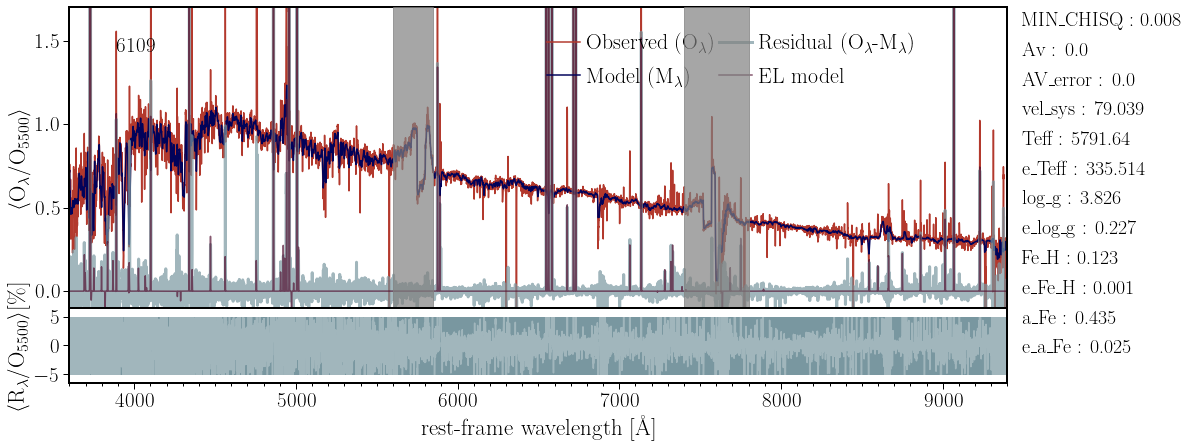

In [121]:
plot_spec(file='output.m_lvmSCFrame-00006109.fits.gz',\
          file_ssp = 'output/m_lvmSCFrame-00006109',\
          name='6109',text='6109')

outfile=fig/6109.pdf
(6, 12401)
12401 0.08395282712711809 0.9780323367704973 11.64978441154339
outfile=fig/6110.pdf
(6, 12401)
12401 0.02998256076838771 0.9746950542755208 32.50873271982813
outfile=fig/6111.pdf
(6, 12401)
12401 0.027568289491519602 0.9748198906213725 35.36018768669855
outfile=fig/6112.pdf
(6, 12401)
12401 0.03763390159458647 0.9573714070208578 25.439068670960573
outfile=fig/6113.pdf
(6, 12401)
12401 0.029744701621058526 0.982116259874054 33.01819168959959
outfile=fig/6114.pdf
(6, 12401)
12401 0.033003426759380596 0.9840156817063613 29.81556093797665
outfile=fig/6115.pdf
(6, 12401)
12401 0.03142148065425939 0.981097757983243 31.223791417679376


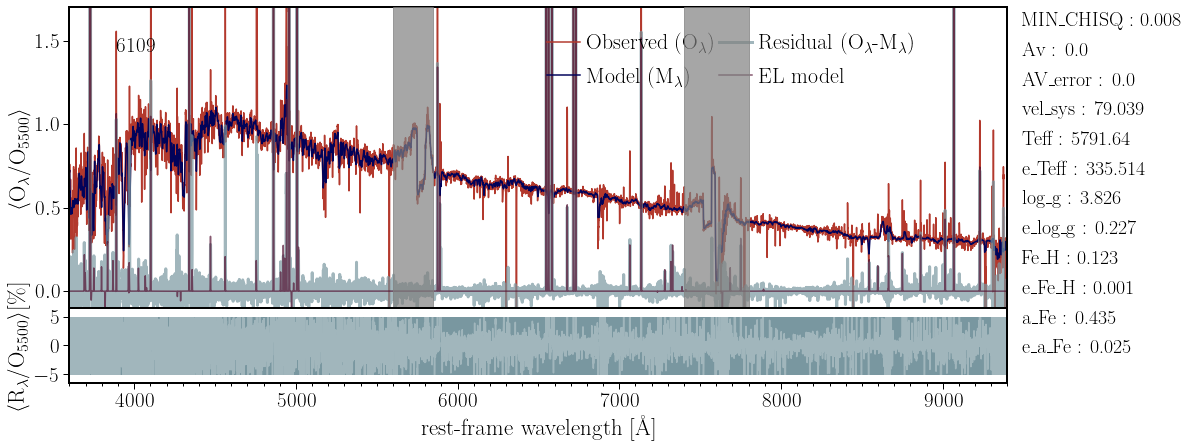

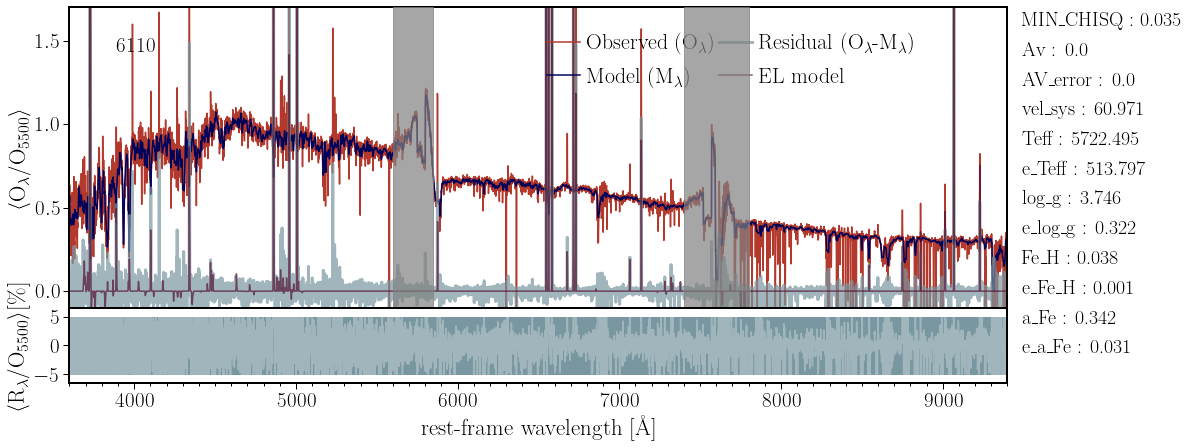

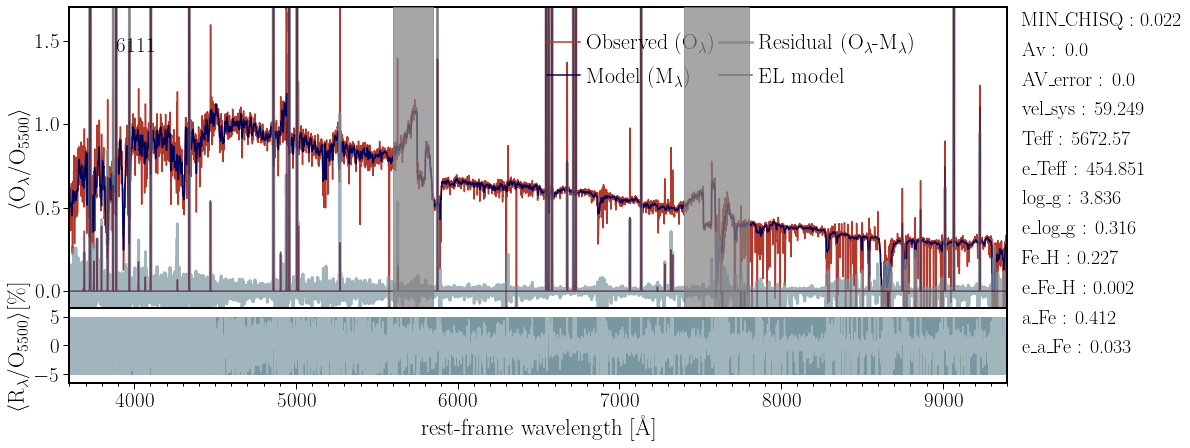

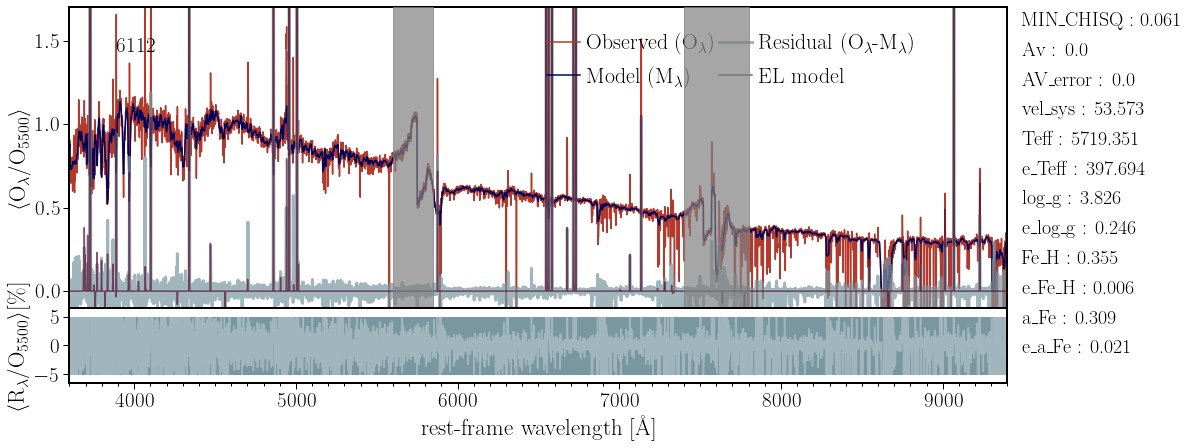

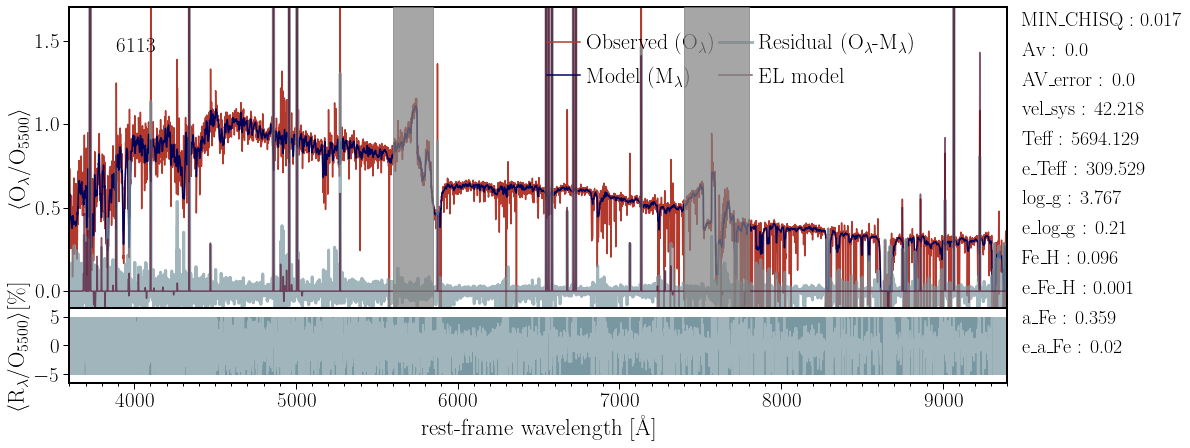

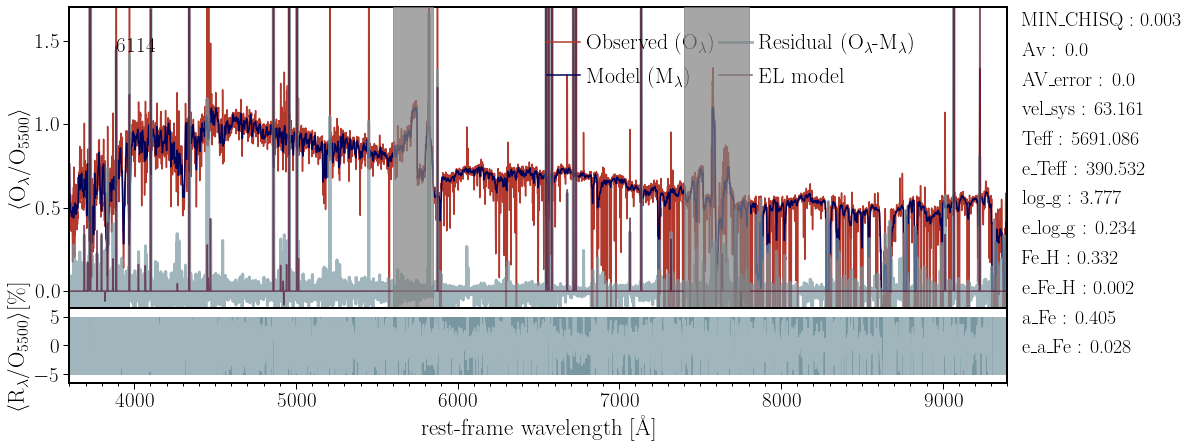

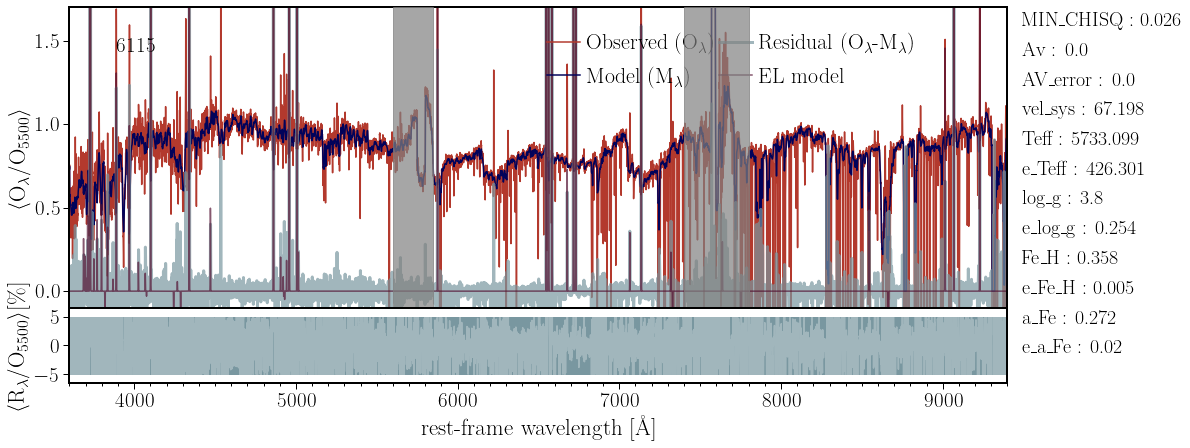

In [54]:
IDs=('6109','6110','6111','6112','6113','6114','6115')
for ids in IDs:
    plot_spec(file=f'output.m_lvmSCFrame-0000{ids}.fits.gz',\
              file_ssp = f'output/m_lvmSCFrame-0000{ids}',\
              name=f'{ids}',text=f'{ids}')

outfile=fig/Ha_6109.pdf
(6, 12401)
12401 0.08395282712711809 0.9780323367704973 11.64978441154339


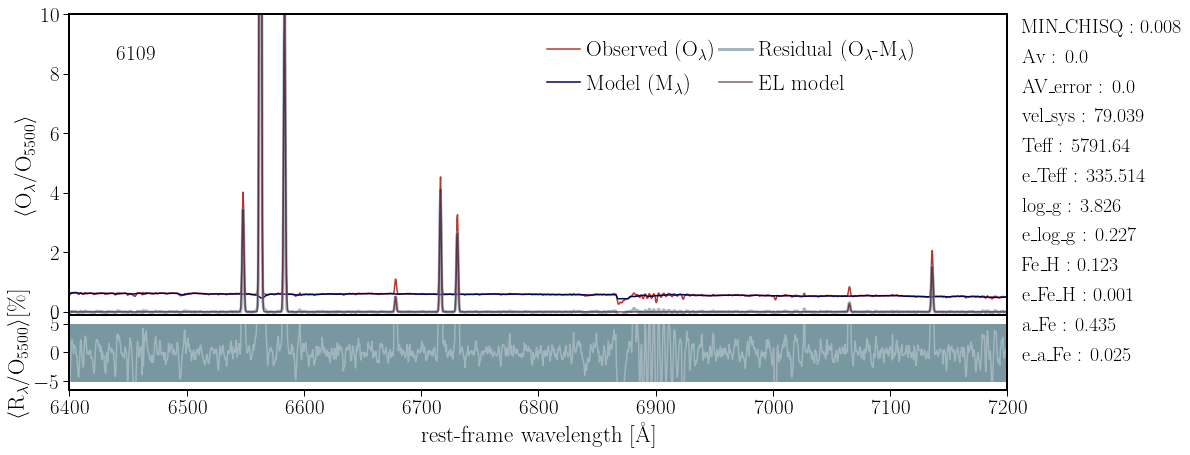

In [55]:
plot_spec(file='output.m_lvmSCFrame-00006109.fits.gz',name='Ha_6109',text='6109',x_min=6400,x_max=7200,y_max=10)

outfile=fig/Ha_6109.pdf
(6, 12401)
12401 0.08395282712711809 0.9780323367704973 11.64978441154339
outfile=fig/Ha_6110.pdf
(6, 12401)
12401 0.02998256076838771 0.9746950542755208 32.50873271982813
outfile=fig/Ha_6111.pdf
(6, 12401)
12401 0.027568289491519602 0.9748198906213725 35.36018768669855
outfile=fig/Ha_6112.pdf
(6, 12401)
12401 0.03763390159458647 0.9573714070208578 25.439068670960573
outfile=fig/Ha_6113.pdf
(6, 12401)
12401 0.029744701621058526 0.982116259874054 33.01819168959959
outfile=fig/Ha_6114.pdf
(6, 12401)
12401 0.033003426759380596 0.9840156817063613 29.81556093797665
outfile=fig/Ha_6115.pdf
(6, 12401)
12401 0.03142148065425939 0.981097757983243 31.223791417679376


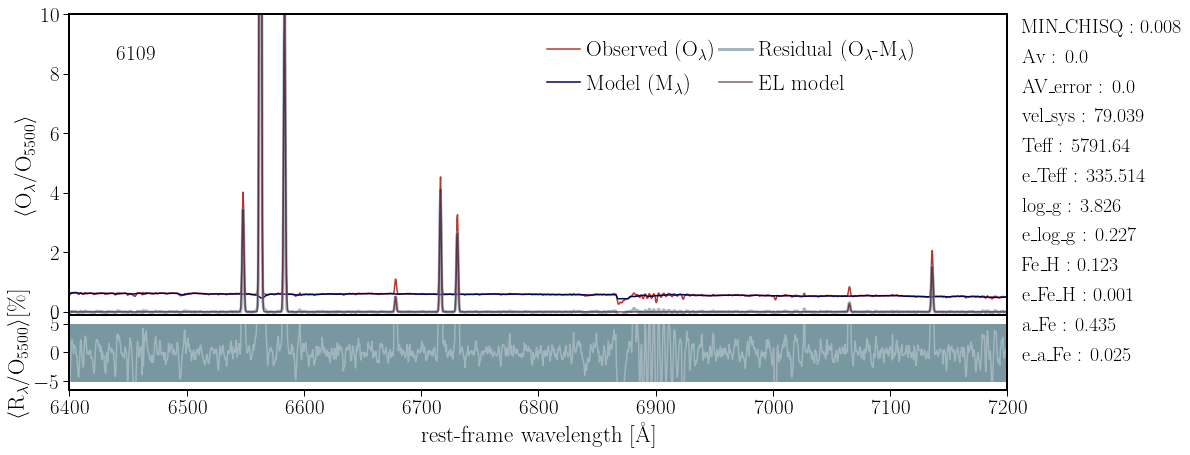

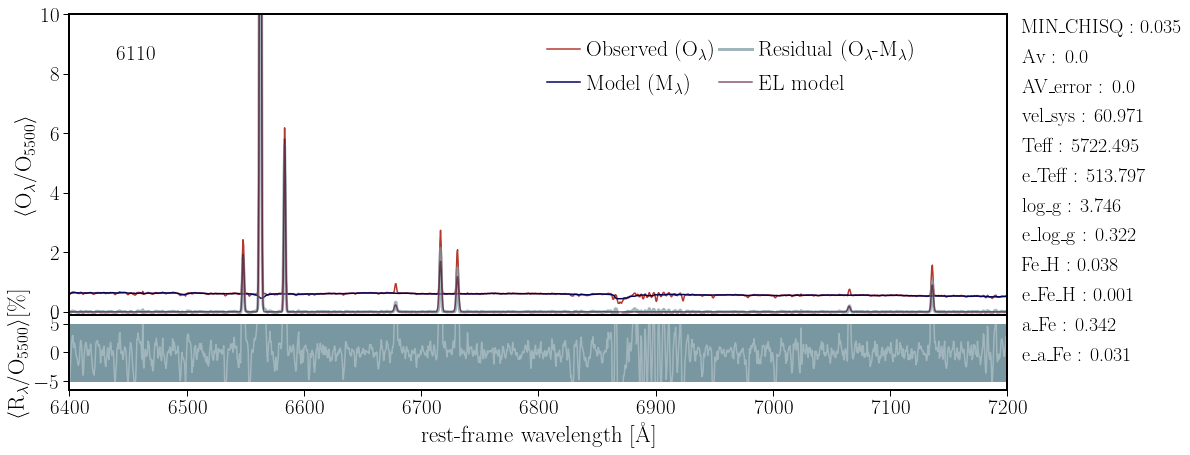

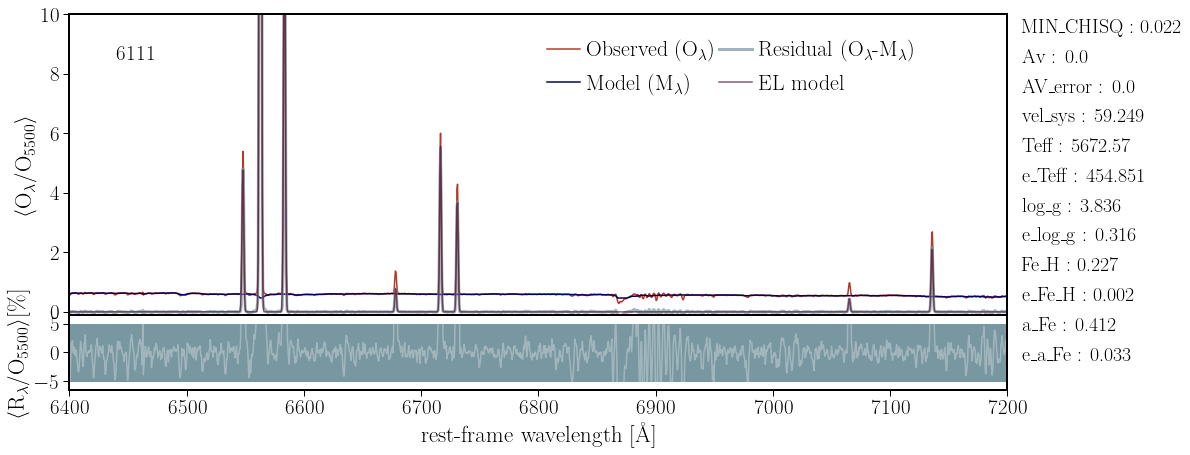

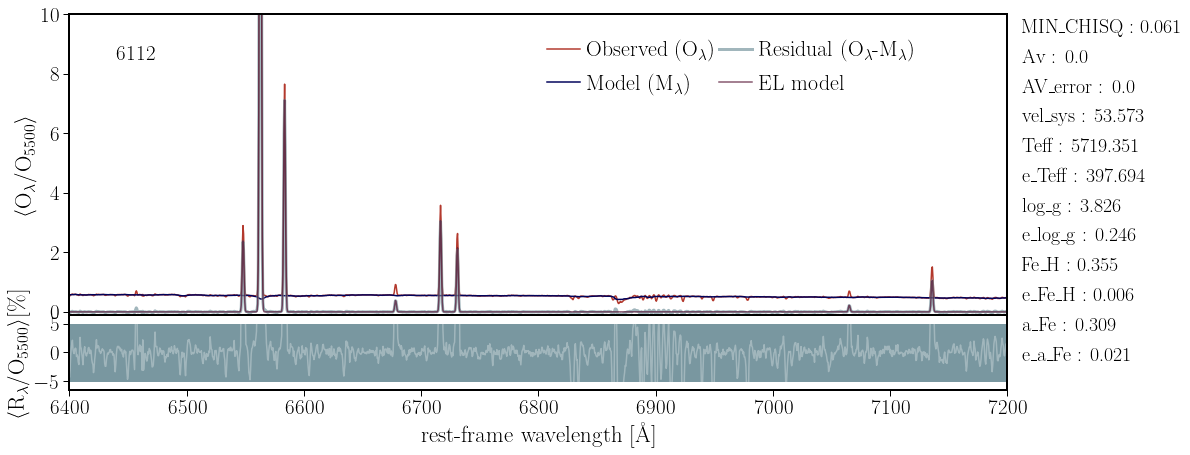

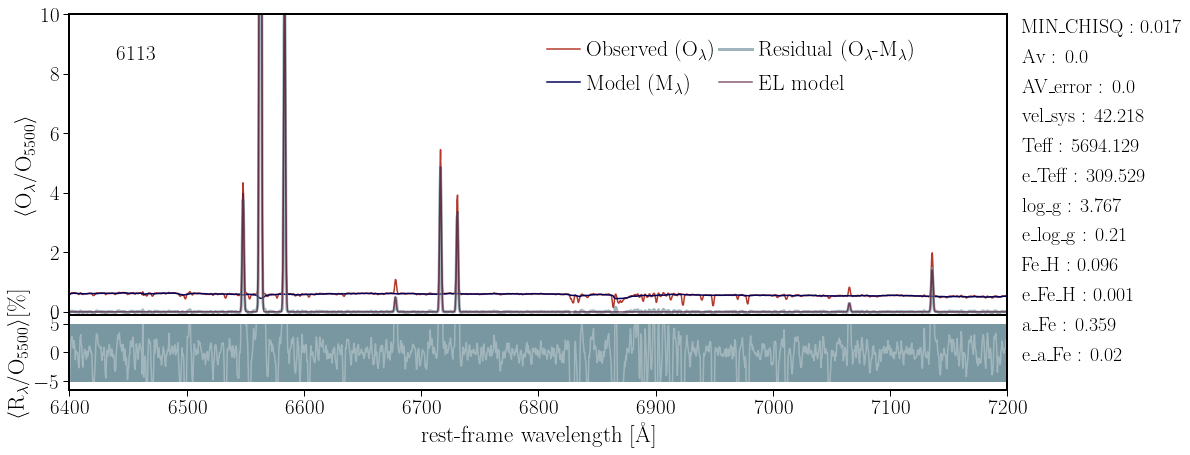

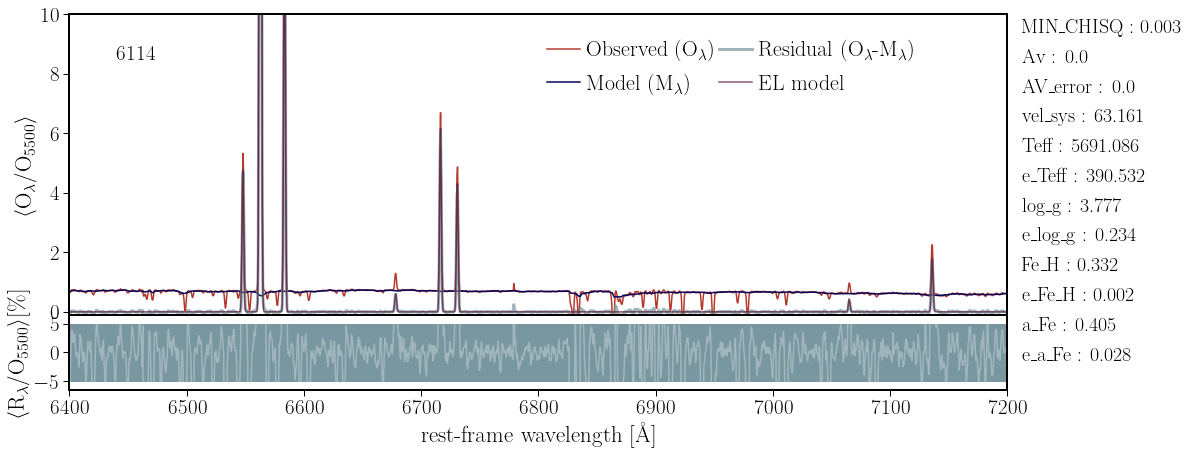

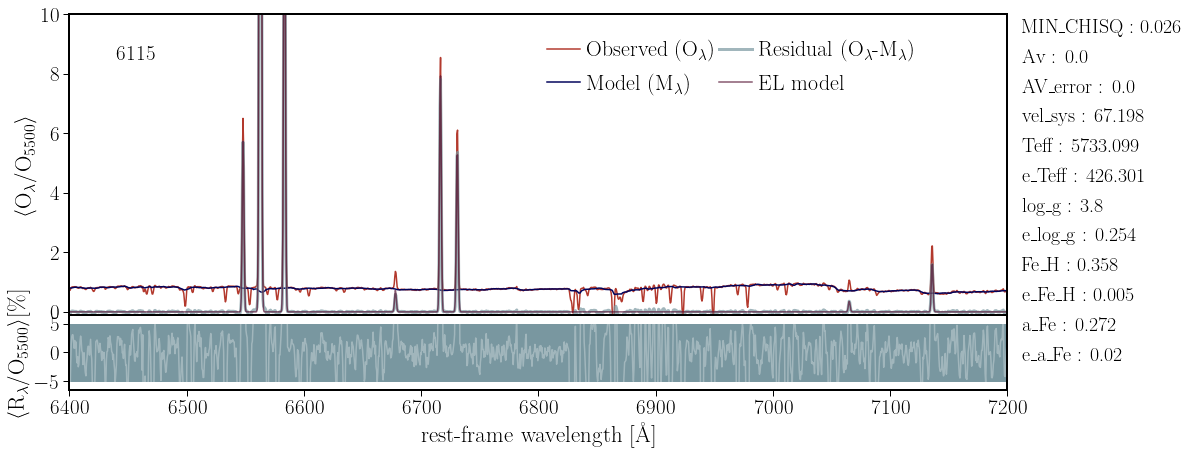

In [56]:
IDs=('6109','6110','6111','6112','6113','6114','6115')
for ids in IDs:
    plot_spec(file=f'output.m_lvmSCFrame-0000{ids}.fits.gz',\
              file_ssp = f'output/m_lvmSCFrame-0000{ids}',\
              name=f'Ha_{ids}',text=f'{ids}',x_min=6400,x_max=7200,y_max=10)

outfile=fig/sec_Ha_He_6109.pdf
(6, 12401)
12401 0.08395282712711809 0.9780323367704973 11.64978441154339


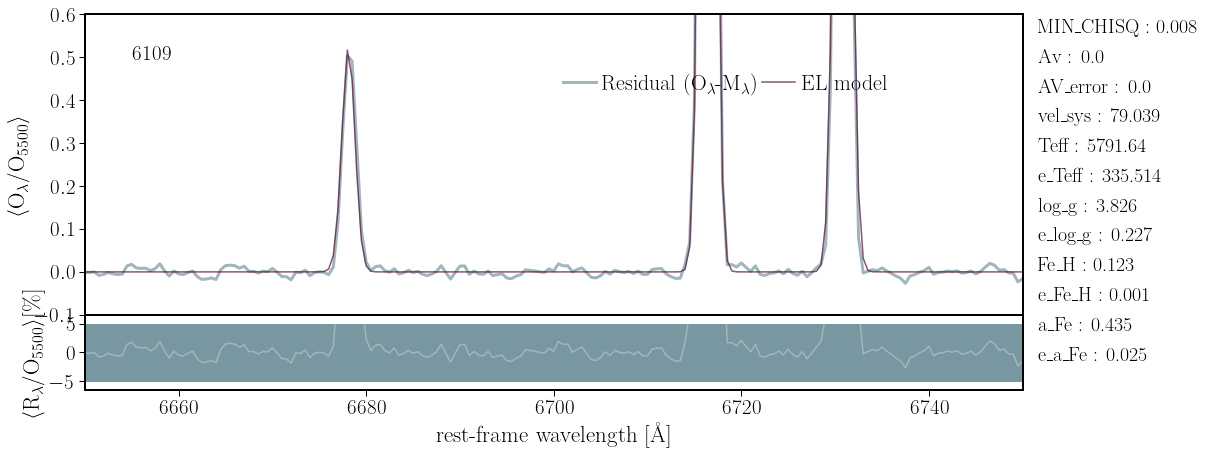

In [57]:
plot_spec(file='output.m_lvmSCFrame-00006109.fits.gz',name='sec_Ha_He_6109',text='6109',\
          x_min=6650,x_max=6750,y_min=-0.1,y_max=0.6,no_st=True)

outfile=fig/sec_Ha_6109.pdf
(6, 12401)
12401 0.08395282712711809 0.9780323367704973 11.64978441154339
outfile=fig/sec_Ha_6110.pdf
(6, 12401)
12401 0.02998256076838771 0.9746950542755208 32.50873271982813
outfile=fig/sec_Ha_6111.pdf
(6, 12401)
12401 0.027568289491519602 0.9748198906213725 35.36018768669855
outfile=fig/sec_Ha_6112.pdf
(6, 12401)
12401 0.03763390159458647 0.9573714070208578 25.439068670960573
outfile=fig/sec_Ha_6113.pdf
(6, 12401)
12401 0.029744701621058526 0.982116259874054 33.01819168959959
outfile=fig/sec_Ha_6114.pdf
(6, 12401)
12401 0.033003426759380596 0.9840156817063613 29.81556093797665
outfile=fig/sec_Ha_6115.pdf
(6, 12401)
12401 0.03142148065425939 0.981097757983243 31.223791417679376


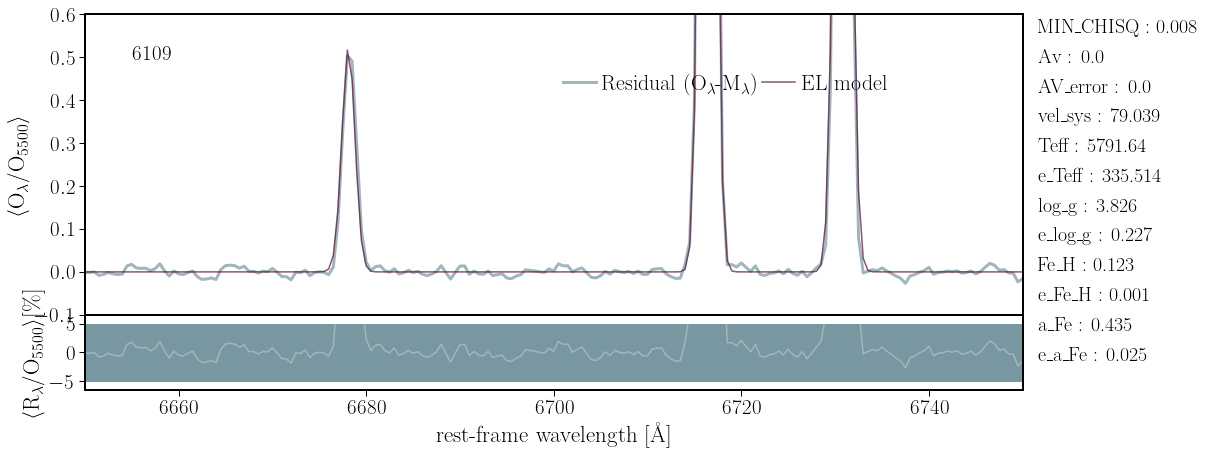

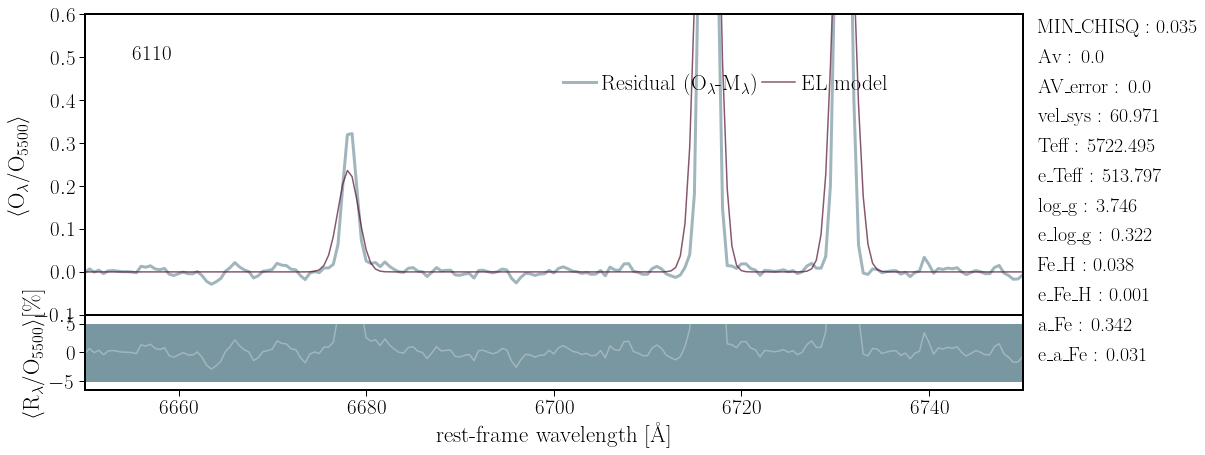

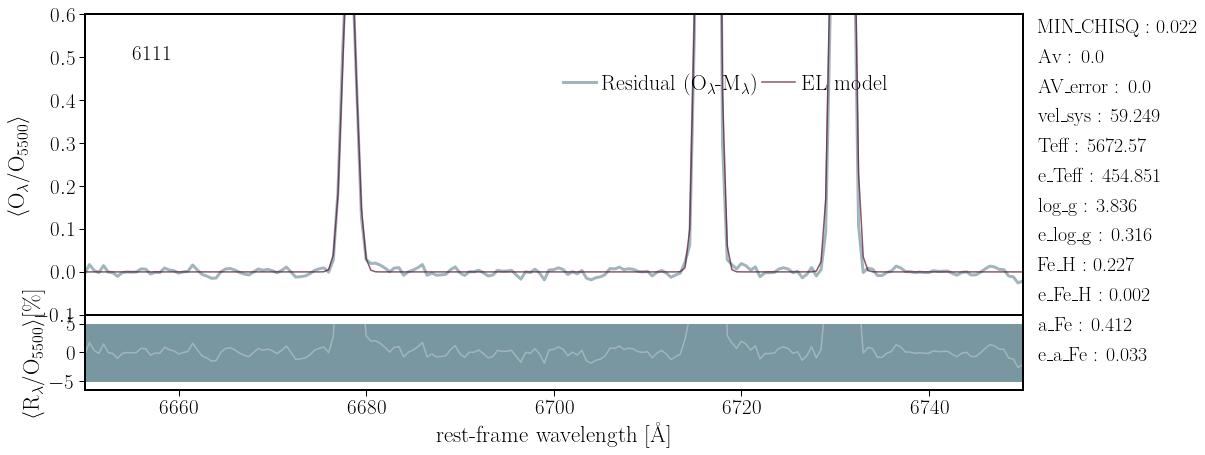

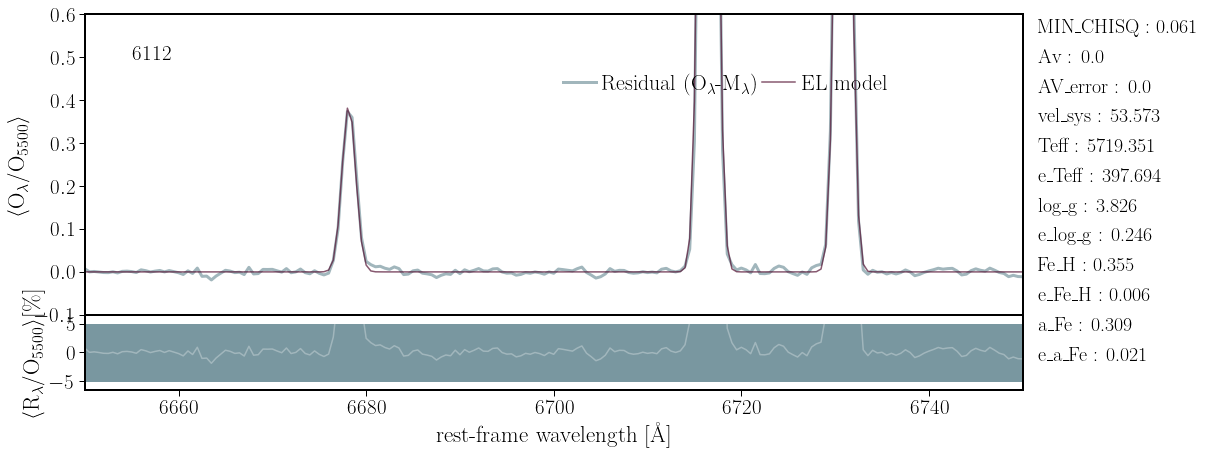

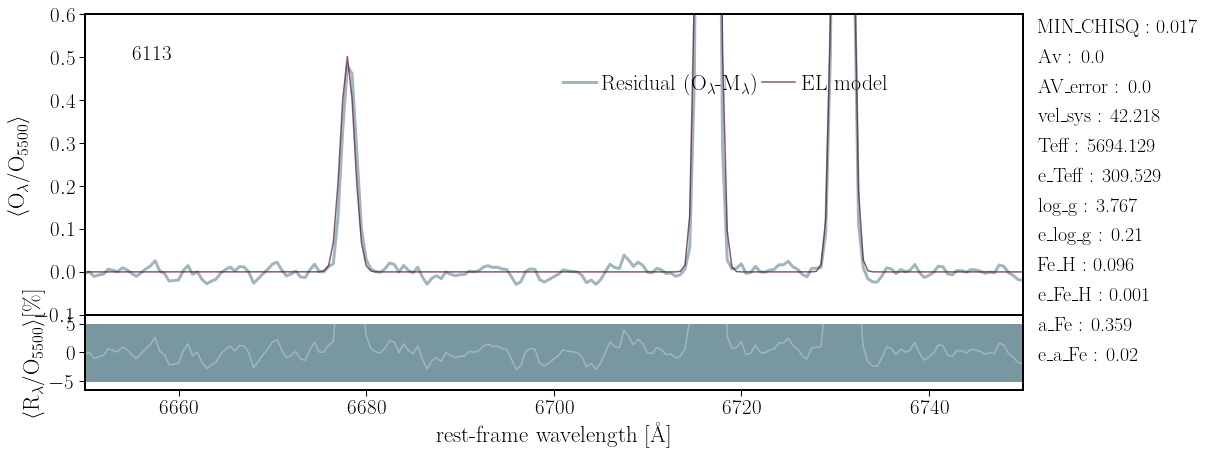

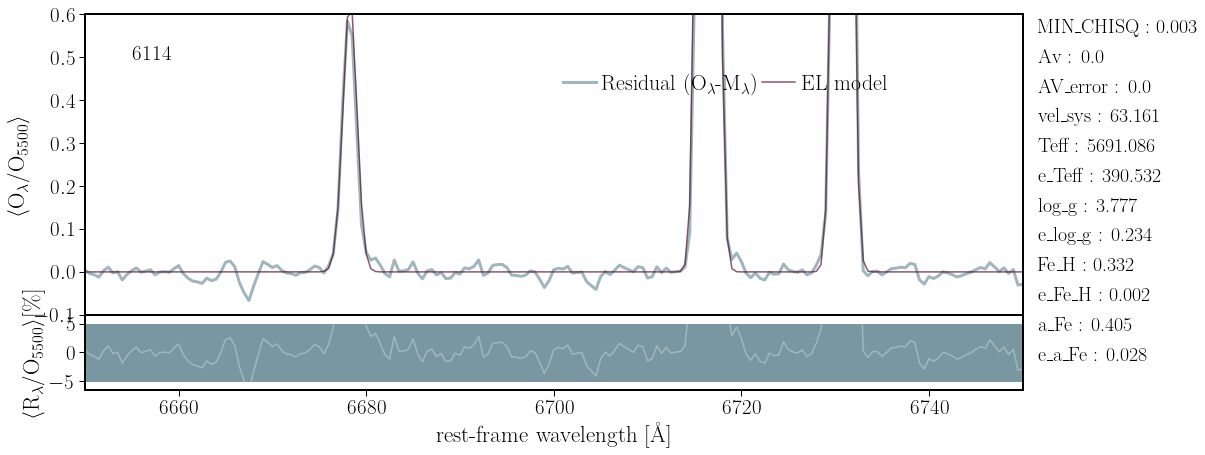

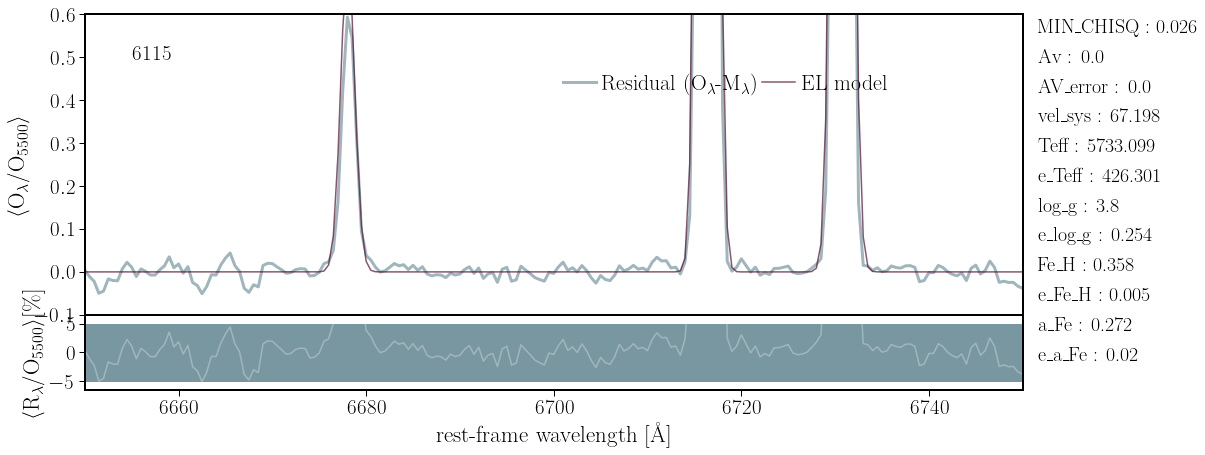

In [58]:
IDs=('6109','6110','6111','6112','6113','6114','6115')
for ids in IDs:
    plot_spec(file=f'output.m_lvmSCFrame-0000{ids}.fits.gz',\
              file_ssp = f'output/m_lvmSCFrame-0000{ids}',\
              name=f'sec_Ha_{ids}',text=f'{ids}',\
              x_min=6650,x_max=6750,y_min=-0.1,y_max=0.6,no_st=True)

outfile=fig/sec_OIII_6110.pdf
(6, 12401)
12401 0.02998256076838771 0.9746950542755208 32.50873271982813


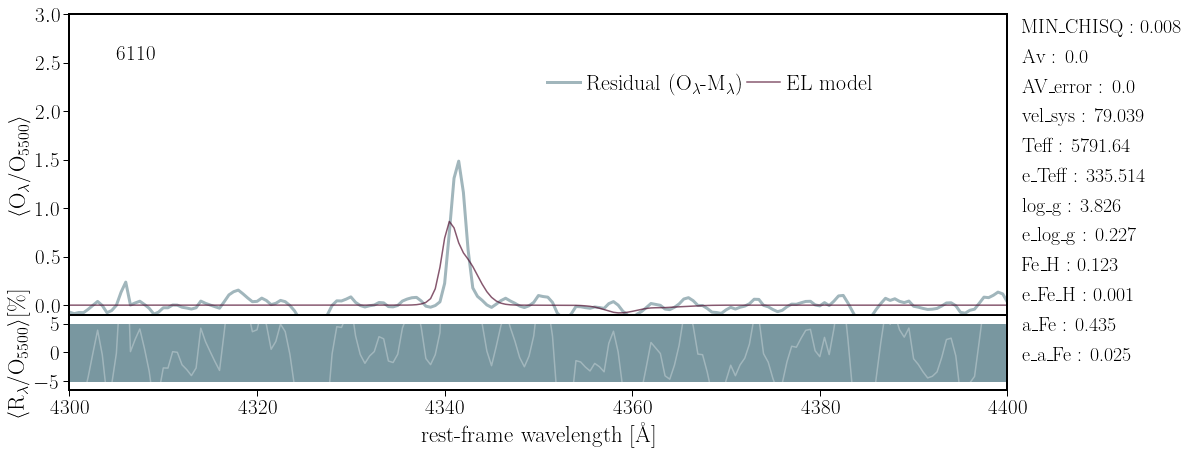

In [59]:
plot_spec(file='output.m_lvmSCFrame-00006110.fits.gz',name='sec_OIII_6110',text='6110',\
          x_min=4300,x_max=4400,y_min=-0.1,y_max=3,no_st=True)

outfile=fig/sec_OIII_6109.pdf
(6, 12401)
12401 0.08395282712711809 0.9780323367704973 11.64978441154339


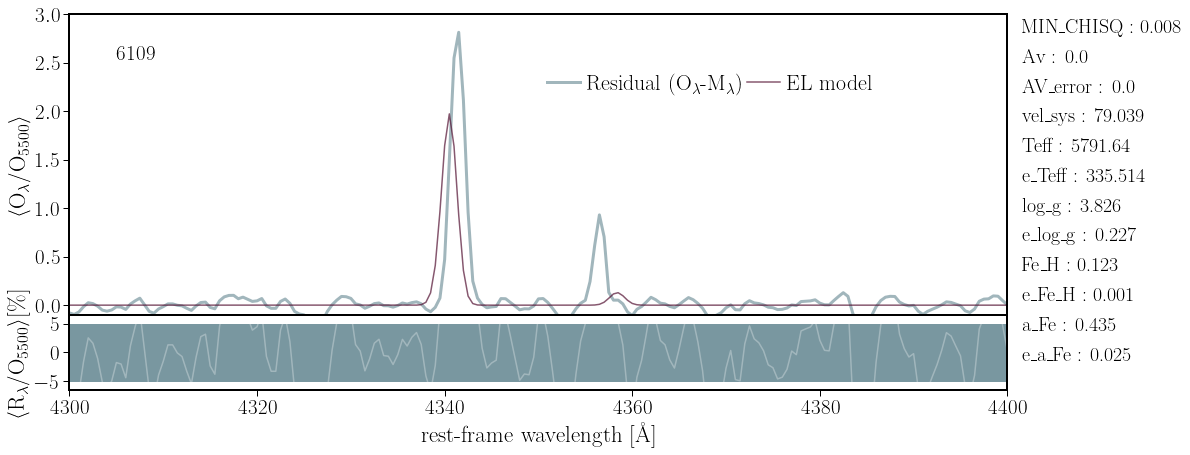

In [60]:
plot_spec(file='output.m_lvmSCFrame-00006109.fits.gz',name='sec_OIII_6109',text='6109',\
          x_min=4300,x_max=4400,y_min=-0.1,y_max=3,no_st=True)

outfile=fig/all.pdf
(6, 12401)
12401 0.027327905523708635 0.9716224766981789 35.554224082604385


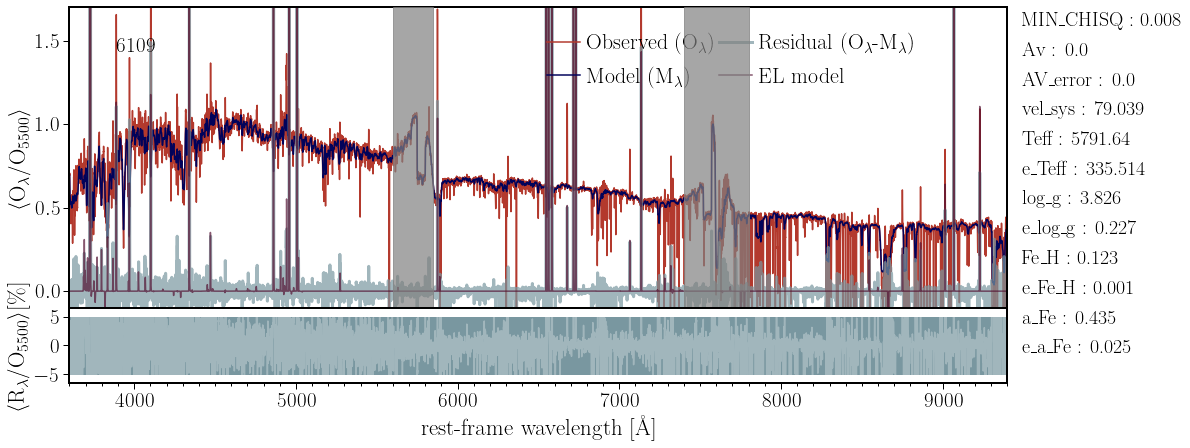

In [61]:
IDs=('6109','6110','6111','6112','6113','6114','6115')
for I,ids in enumerate(IDs):
    file=f'output/output.m_lvmSCFrame-0000{ids}.fits.gz'
    hdu=fits.open(file)
    if (I==0):
        data=hdu[0].data
        hdr=hdu[0].header
    else:
        data=data+hdu[0].data

data=data/len(IDs)
hdu_out=fits.PrimaryHDU(data=data,header=hdr)
hdu_out.writeto('output/output.all_Rosetta.fits.gz',overwrite=True)
        
    
plot_spec(file='output.all_Rosetta.fits.gz',\
          file_ssp = 'output/m_lvmSCFrame-00006109',\
          name='all',text='6109')



In [113]:
col_elines=header_columns_space('/disk-a/sanchez/ppak/legacy/emission_lines_long_list.LVM',2)
tab_elines=ascii.read('/disk-a/sanchez/ppak/legacy/emission_lines_long_list.LVM',\
                      delimiter=' ', guess=True, comment='\s*#', names=col_elines,\
                       fill_values=[('BAD', np.nan)])

tab_elines
#    
#elines=np.loadtxt('/disk-a/sanchez/ppak/legacy/emission_lines_long_list.LVM',delimiter=' ')#,\
#                  dtype={'names': ('wl', 'eline'),\
#                         'formats': ('f4', 'S1')})

<Table length=192>
   wl    eline 
float64   str8 
------- -------
3686.83      HI
3691.56      HI
3697.15      HI
3703.85      HI
3711.97      HI
3726.03   [OII]
3728.82   [OII]
3734.37      HI
3750.15      HI
 3758.9 [FeVII]
    ...     ...
 9123.6  [ClII]
 9226.6  [FeII]
9229.02      HI
 9266.0      OI
9267.54  [FeII]
9399.02  [FeII]
9470.93  [FeII]
 9531.1  [SIII]
9545.97      HI
9682.13  [FeII]

outfile=fig/sec_all_3600.pdf
(6, 12401)
12401 0.027327905523708635 0.9716224766981789 35.554224082604385
outfile=fig/sec_all_3600_zoom.pdf
(6, 12401)
12401 0.027327905523708635 0.9716224766981789 35.554224082604385
outfile=fig/sec_all_4125.pdf
(6, 12401)
12401 0.027327905523708635 0.9716224766981789 35.554224082604385
outfile=fig/sec_all_4125_zoom.pdf
(6, 12401)
12401 0.027327905523708635 0.9716224766981789 35.554224082604385
outfile=fig/sec_all_4650.pdf
(6, 12401)
12401 0.027327905523708635 0.9716224766981789 35.554224082604385
outfile=fig/sec_all_4650_zoom.pdf
(6, 12401)
12401 0.027327905523708635 0.9716224766981789 35.554224082604385
outfile=fig/sec_all_5175.pdf
(6, 12401)
12401 0.027327905523708635 0.9716224766981789 35.554224082604385
outfile=fig/sec_all_5175_zoom.pdf
(6, 12401)
12401 0.027327905523708635 0.9716224766981789 35.554224082604385
outfile=fig/sec_all_5700.pdf
(6, 12401)
12401 0.027327905523708635 0.9716224766981789 35.554224082604385
outfile=fig/sec_all_5700_zoom.pdf
(

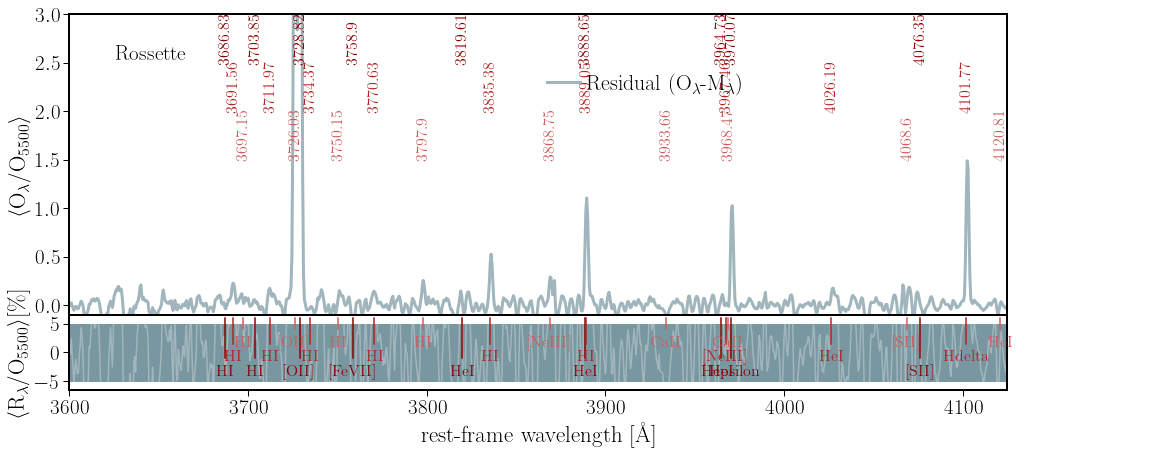

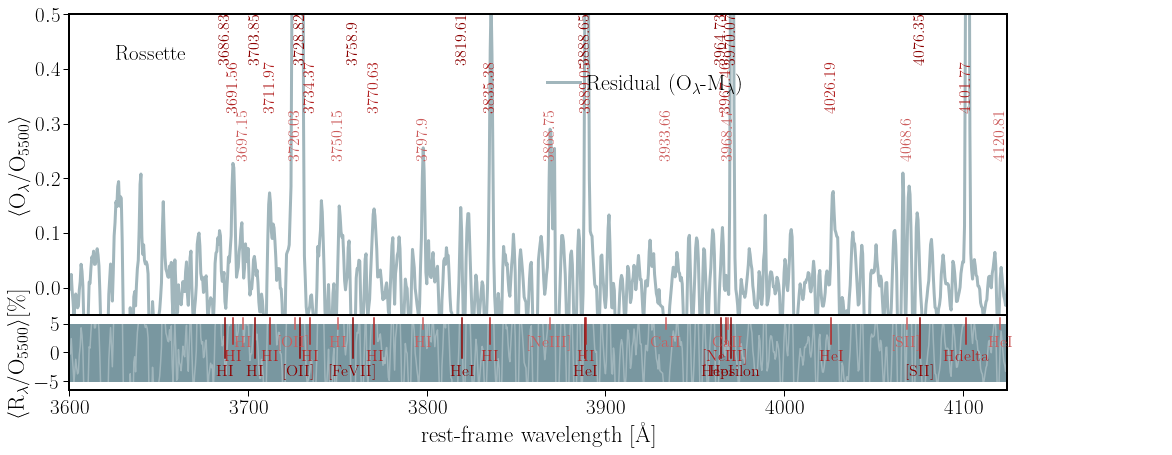

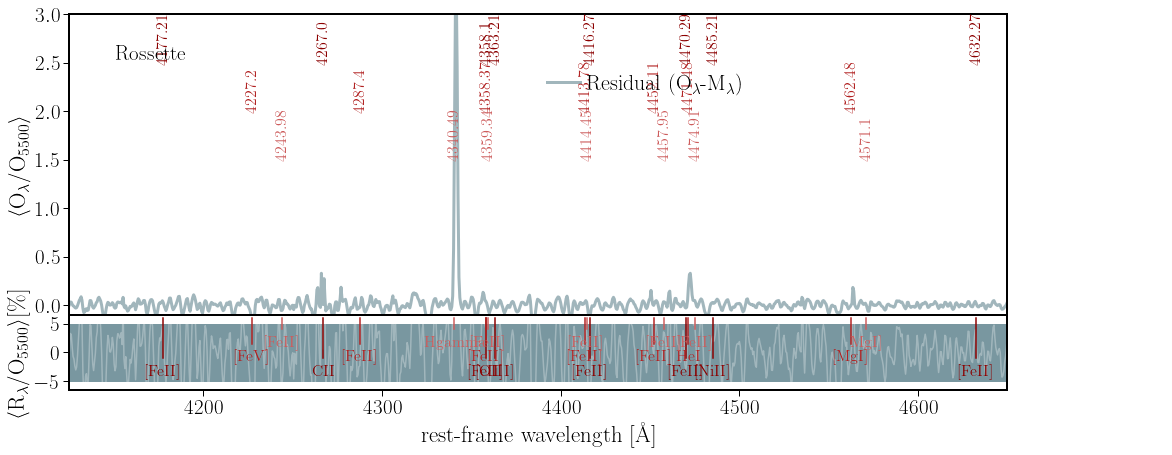

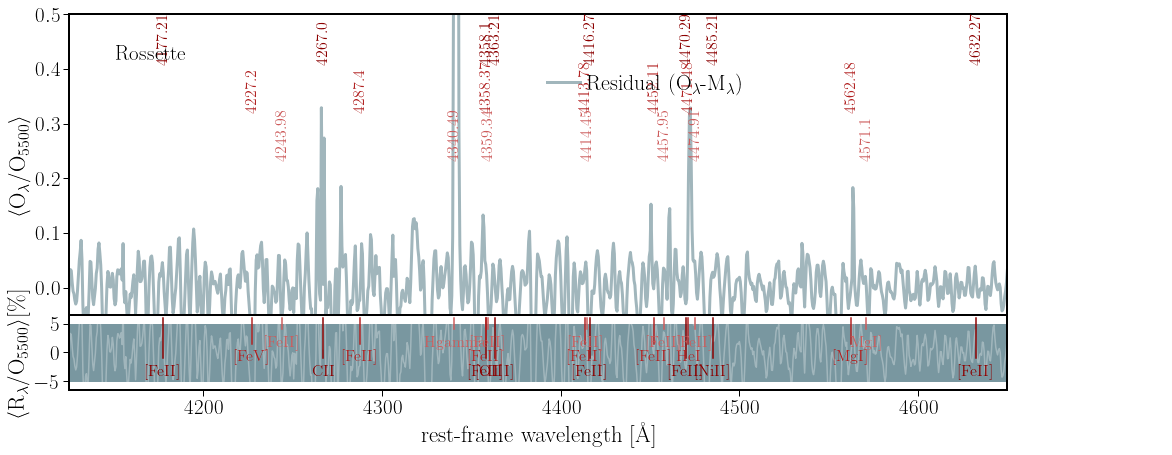

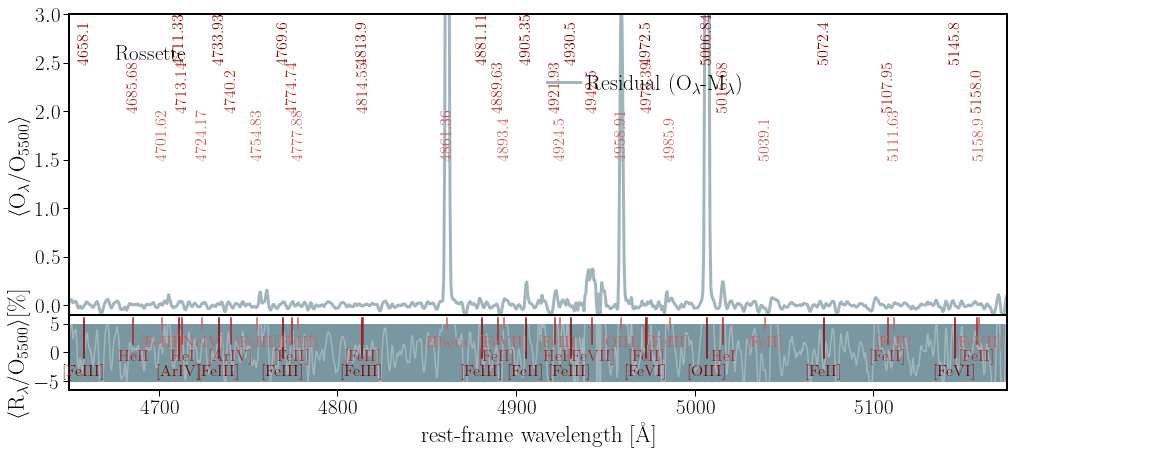

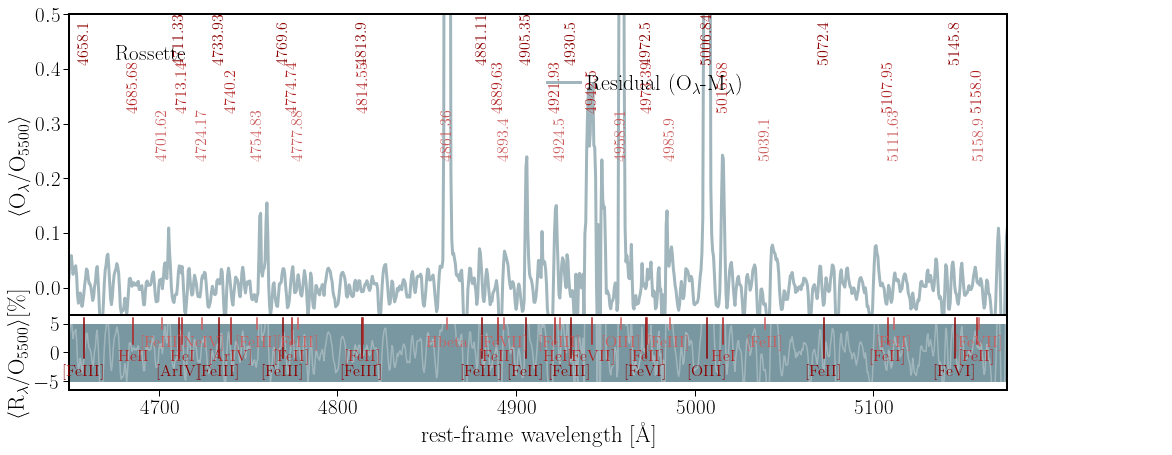

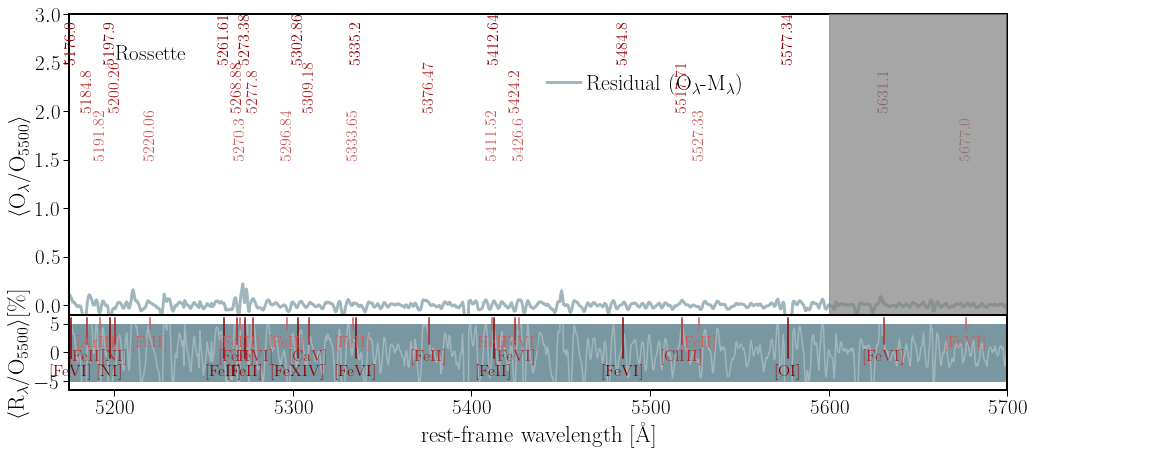

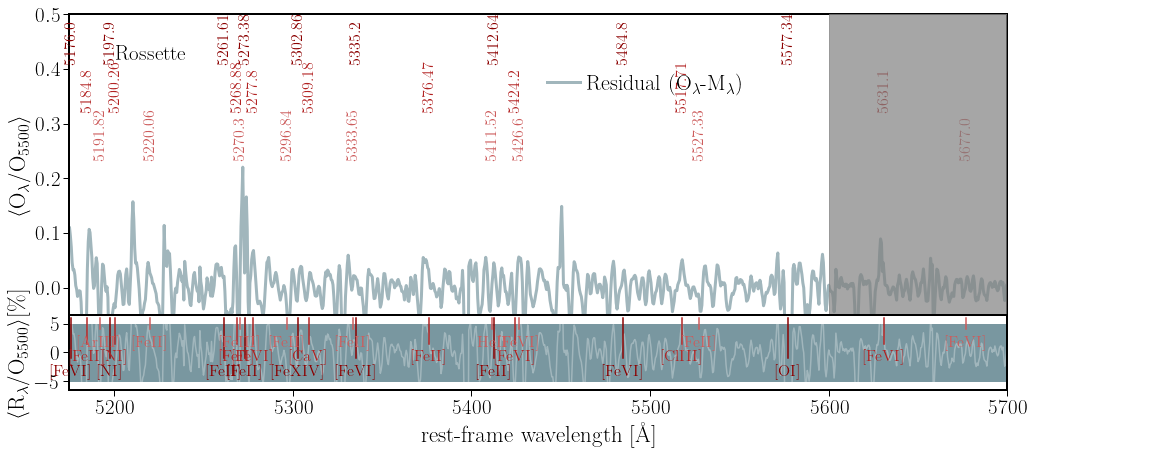

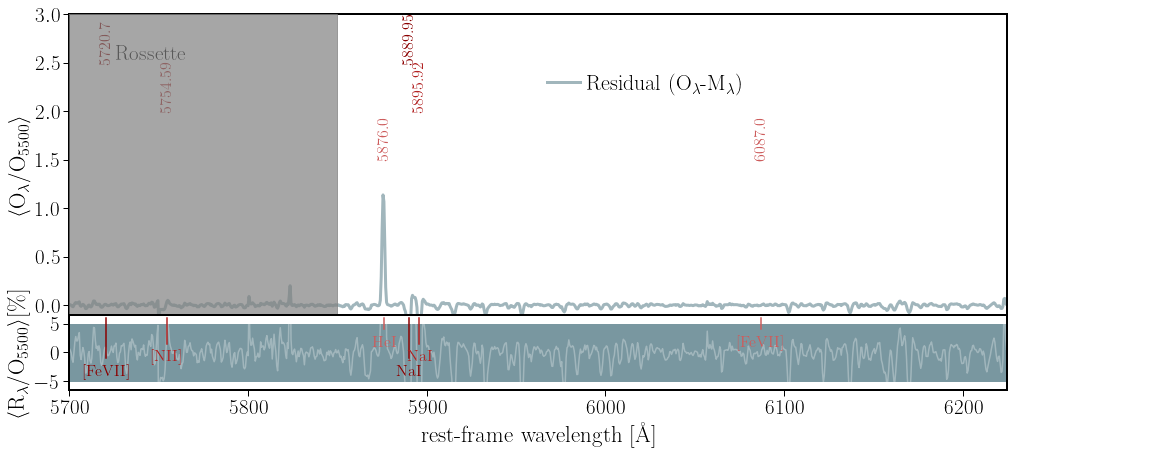

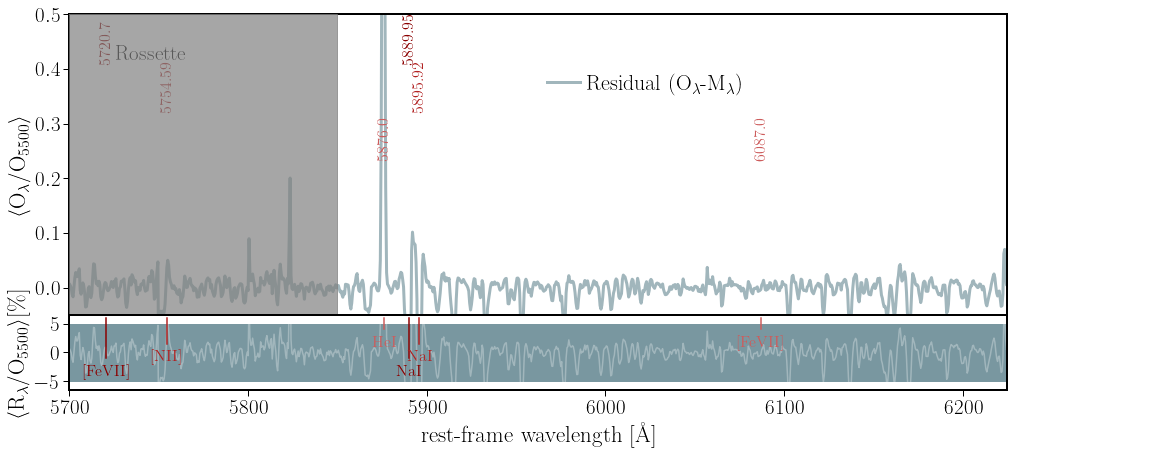

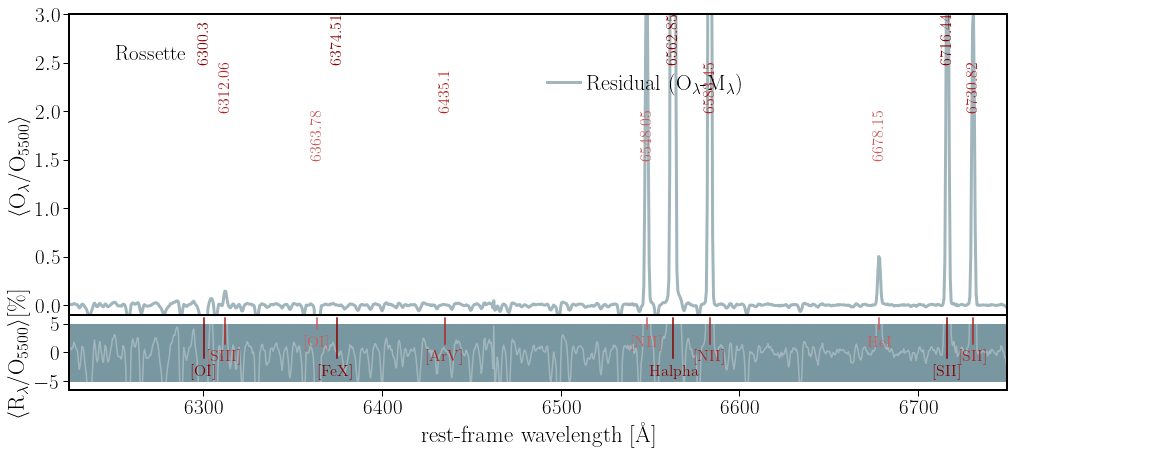

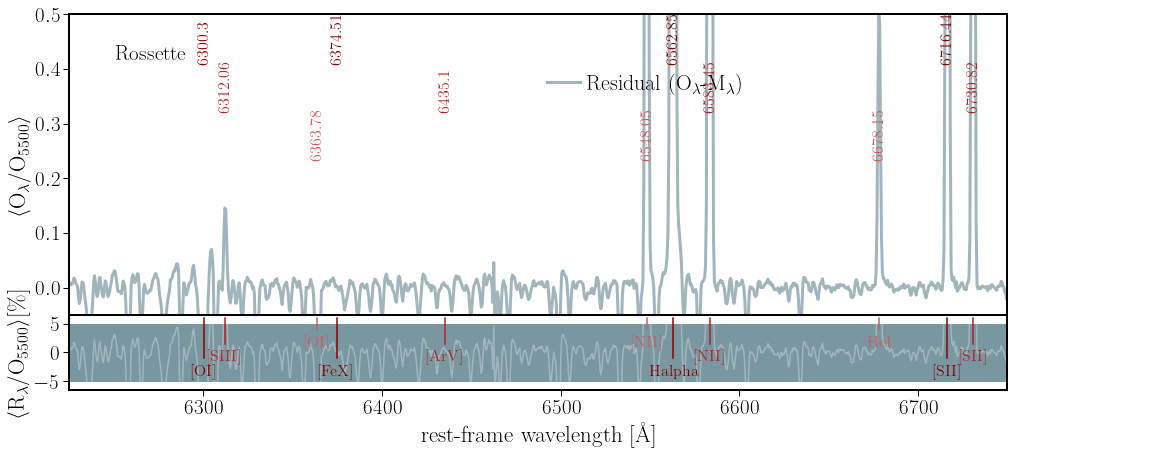

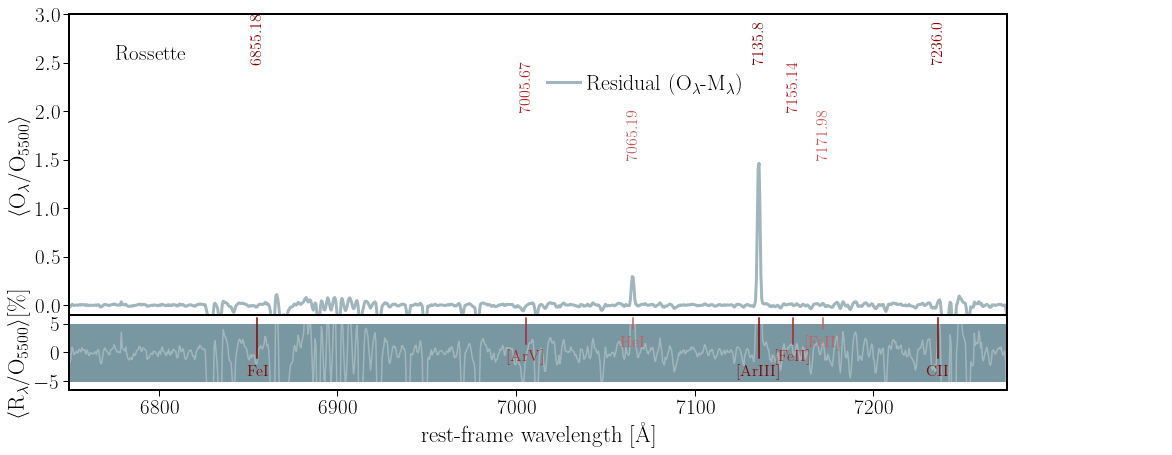

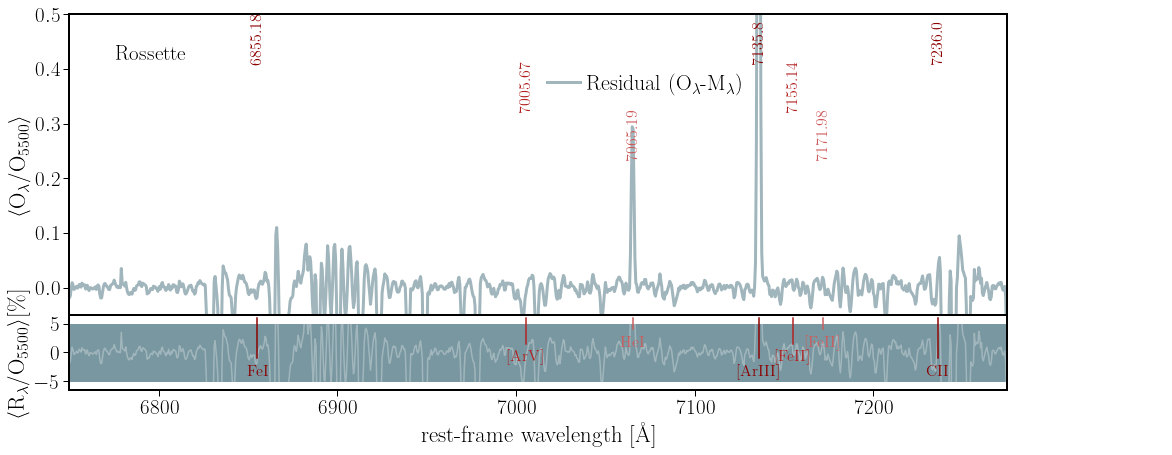

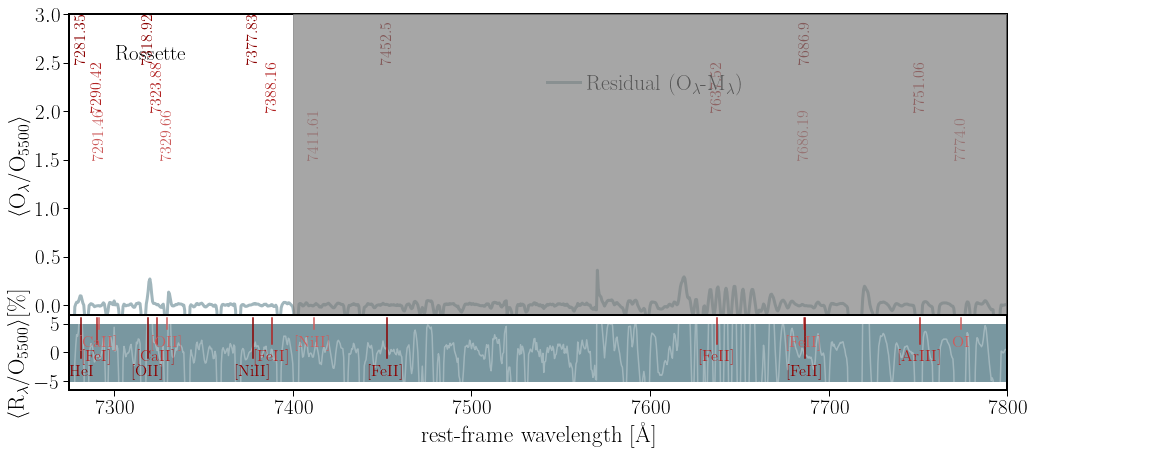

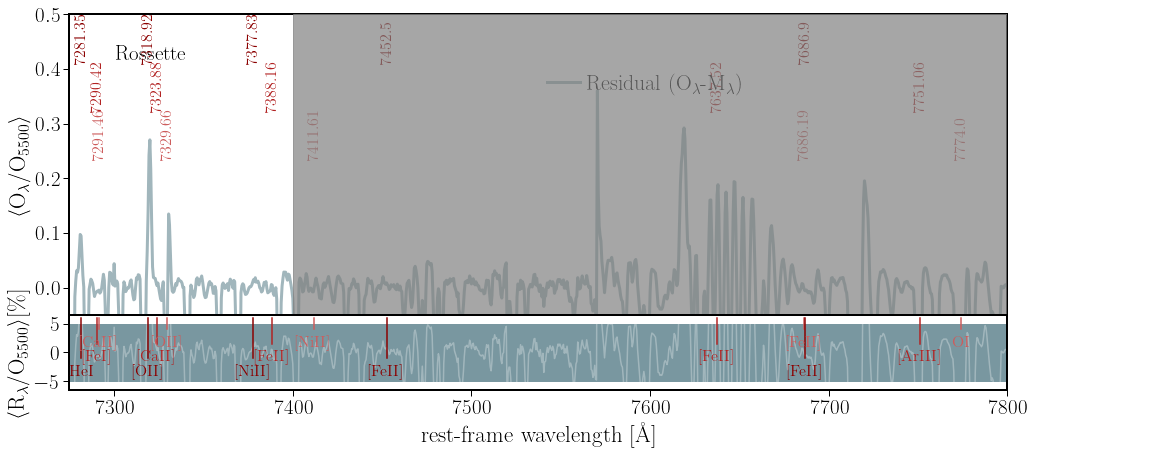

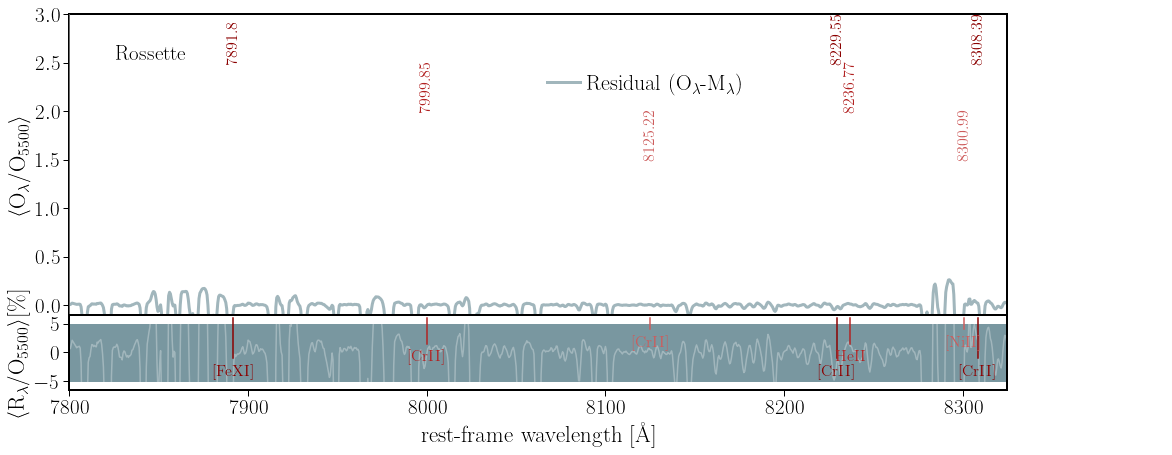

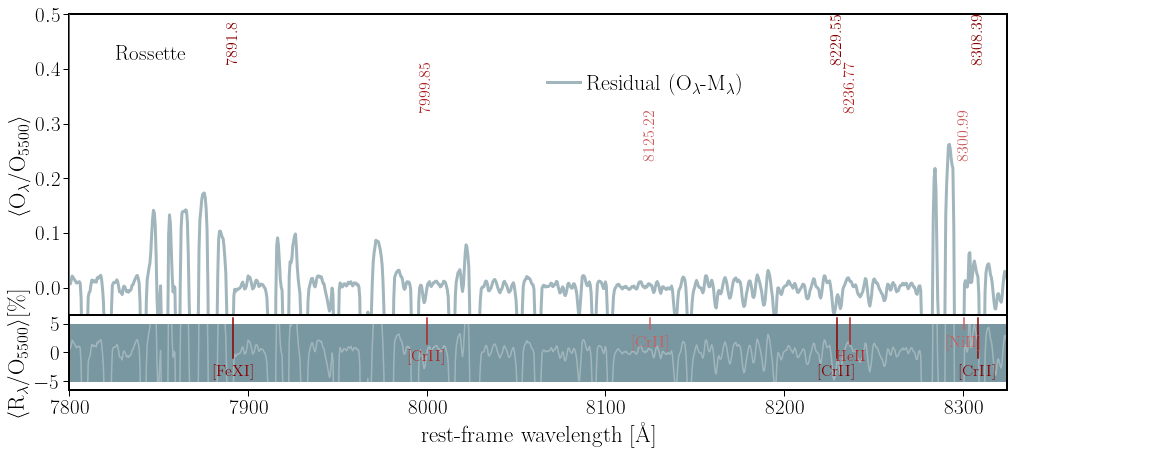

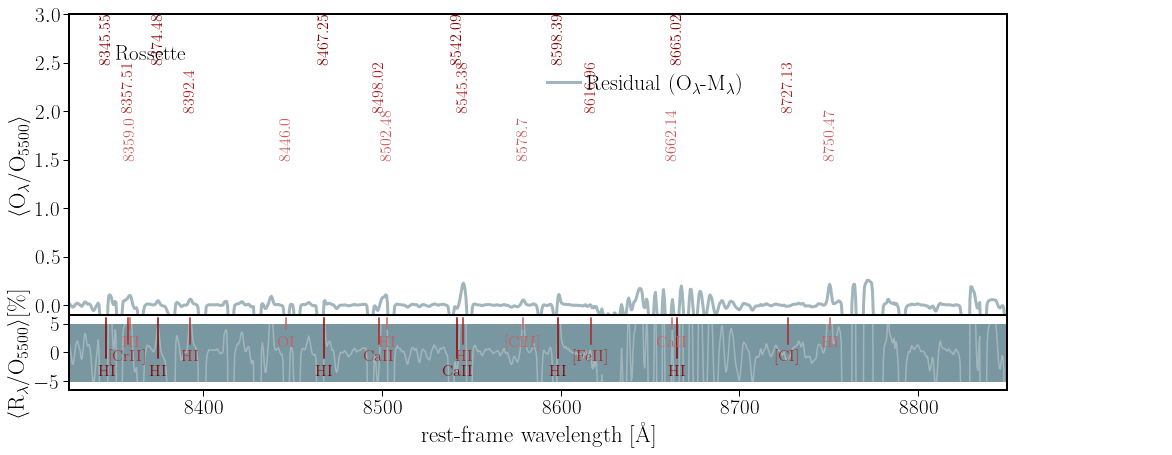

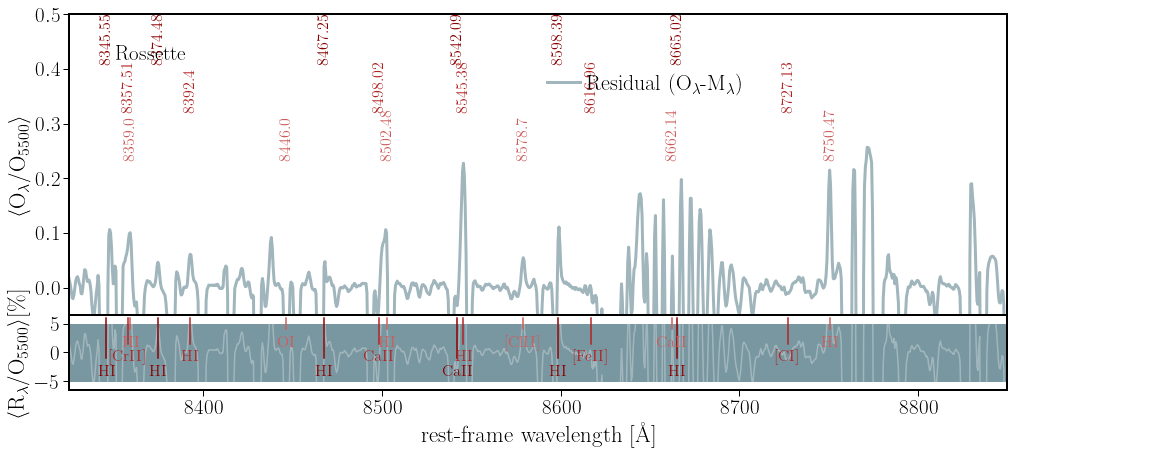

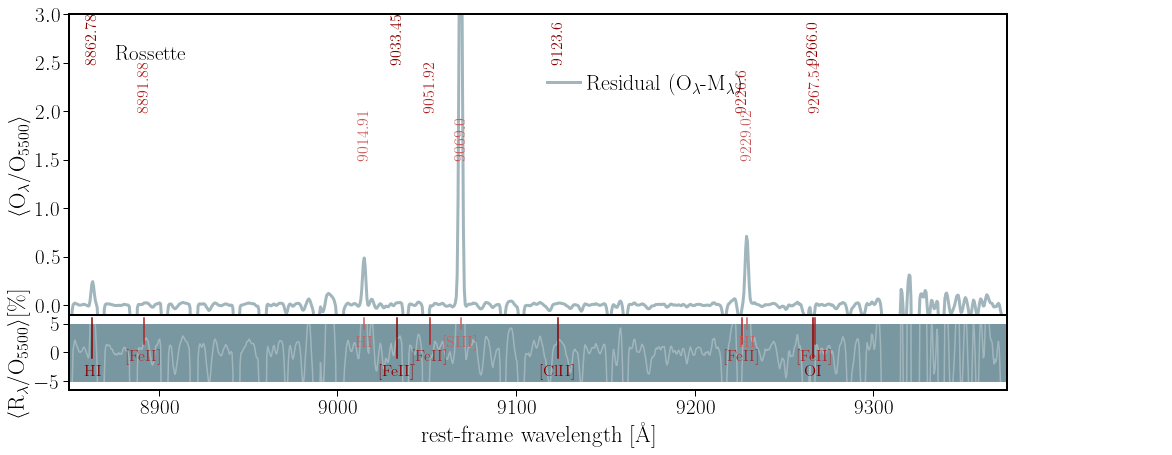

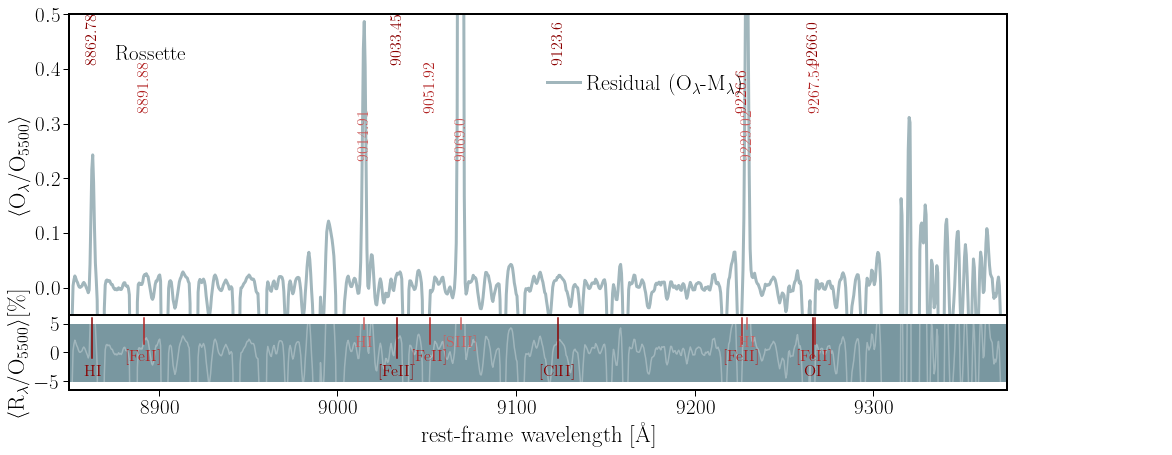

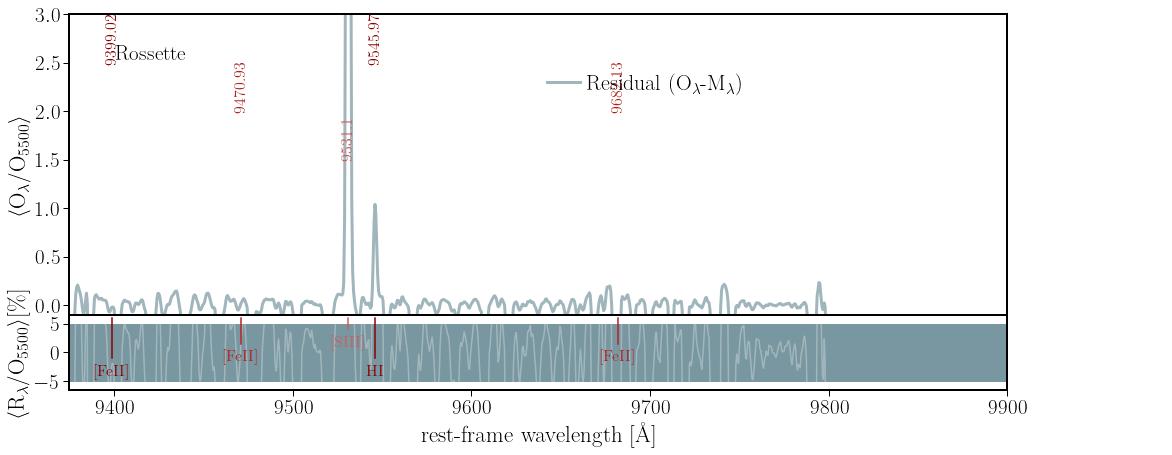

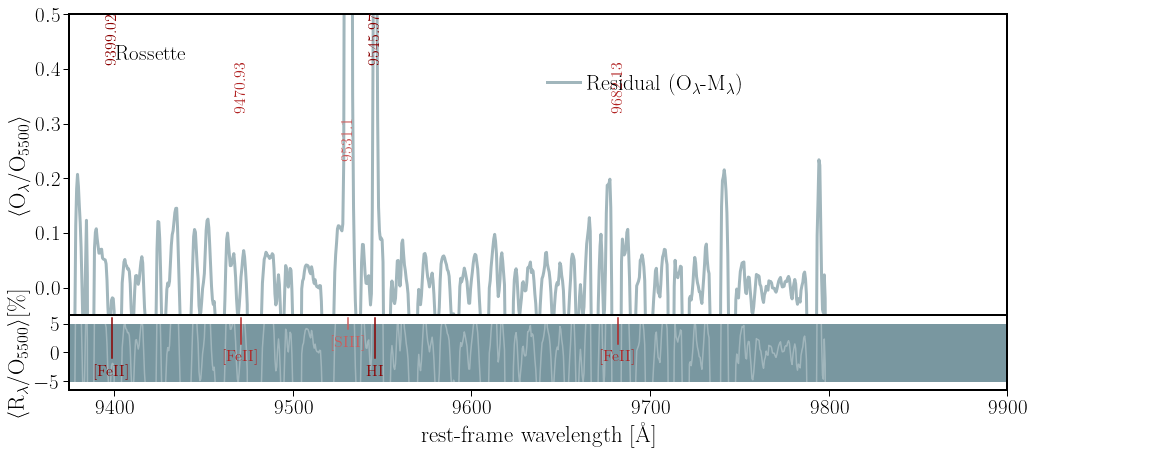

In [165]:
w0=3600
#w1=1050
w1=525
#waves=w0+w1*np.arange(6)
waves=w0+w1*np.arange(12)
for w in waves:
    plot_spec(file='output.all_Rosetta.fits.gz',\
              file_ssp = 'output/m_lvmSCFrame-00006109',\
              name=f'sec_all_{w}',text='Rossette',\
              x_min=w,x_max=w+w1,y_min=-0.1,y_max=3,no_st=True,no_model=True,id_lines=tab_elines)
    
    plot_spec(file='output.all_Rosetta.fits.gz',\
              file_ssp = 'output/m_lvmSCFrame-00006109',\
              name=f'sec_all_{w}_zoom',text='Rossette',\
              x_min=w,x_max=w+w1,y_min=-0.05,y_max=0.5,no_st=True,no_model=True,id_lines=tab_elines)

In [63]:
#noise_plot(beta=2.5,d_bin=0.1)

NameError: name 'noise_plot' is not defined